<span style="color:red">
To get this notebook running, please install: <br> 
1. sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config <br>
2. pip install pygraphviz
</span>

In [1]:
import sys
import os

repo_path = os.path.sep.join(os.getcwd().split(os.path.sep)[:-3])
sys.path.append(repo_path)
%cd ../../..


/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
%pip install -r practical/DeepClustering/DeepECT/requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from practical.DeepClustering.DeepECT.evaluation_pipeline import DatasetType, get_dataset, evaluate_multiple_seeds, calculate_flat_mean_for_multiple_seeds, calculate_hierarchical_mean_for_multiple_seeds
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_custom_dataloader_augmentations, DatasetType, AutoencoderType, pretraining
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
from practical.DeepClustering.DeepECT.metrics_visualization import visualize_peformance_AE, load_results, visualize_perfomance_multiple_AE
from sklearn.preprocessing import minmax_scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DeepECT - Deep Embedded Cluster Tree
## Results

In [3]:
(
    flat_results,
    flat_combined,
    flat_results_html,
    hierarchical_results,
    hierarchical_combined,
    hierarchical_results_html,
) = load_results()

/home/loebbert/projects/deepclustering/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/metrics_visualization.py:462: FutureWarning: The provided callable <function mean at 0x7fafac3992d0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  flat_combined_df.pivot_table(
/home/loebbert/projects/deepclustering/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/metrics_visualization.py:546: FutureWarning: The provided callable <function mean at 0x7fafac3992d0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  hierarchical_combined.pivot_table(


In [17]:
from practical.DeepClustering.DeepECT.evaluation_pipeline import ClusteringMethod
deepect_filtered = flat_combined[flat_combined["method"].str.startswith("DeepECT")]

In [20]:
deepect_filtered.pivot_table(index=[
            "method",
        ],
        columns=["dataset"],
        values=[
            "acc",
        ],margins=True,
               margins_name='total',  # defaults to 'All'
               aggfunc=np.mean)

acc                                \
dataset                        Fashion MNIST     MNIST   Reuters      USPS   
method                                                                       
DeepECT (Ours)                      0.502050  0.734250  0.452724  0.706173   
DeepECT (Paper)                     0.502661  0.814646  0.455006  0.728275   
DeepECT + Augmentation (Ours)       0.408257  0.815532       NaN  0.653178   
DeepECT + Augmentation (Paper)      0.470896  0.796189       NaN  0.728221   
total                               0.479924  0.790154  0.453865  0.703962   

                                          
dataset                            total  
method                                    
DeepECT (Ours)                  0.598799  
DeepECT (Paper)                 0.625147  
DeepECT + Augmentation (Ours)   0.669136  
DeepECT + Augmentation (Paper)  0.665102  
total                           0.634365

In [15]:
flat_combined.dropna(how="all").pivot_table(index=[
            "autoencoder",
        ],
        columns=["dataset"],
        values=[
            "acc",
        ],margins=True,
               margins_name='total',  # defaults to 'All'
               aggfunc=np.mean)

acc                                        
dataset                 Fashion MNIST     MNIST   Reuters      USPS     total
autoencoder                                                                  
ClustPy FeedForward          0.486445  0.811158  0.524968  0.718031  0.645167
Stacked AE from DeepECT      0.505497  0.791674  0.492019  0.667007  0.630840
total                        0.495105  0.801416  0.508494  0.692519  0.638170

# Autoencoder
For all datasets except Fashion MNIST, the standard feedforward autoencoder seems to perform best.

# Method
The paper version (having adaptations that bring our implemneation more towards the paper's implementation) performs better.

In [5]:
flat_results["MNIST"]

nmi         acc  \
                                                        mean   std  mean   
autoencoder             method                                             
Stacked AE from DeepECT DeepECT (Ours)                  0.82  0.05  0.86   
                        DeepECT (Paper)                 0.00  0.00  0.00   
                        DeepECT + Augmentation (Ours)   0.53  0.38  0.48   
                        DeepECT + Augmentation (Paper)  0.85  0.03  0.85   
                        IDEC                            0.85  0.01  0.86   
                        KMeans                          0.72  0.00  0.78   

                                                               ari        
                                                         std  mean   std  
autoencoder             method                                            
Stacked AE from DeepECT DeepECT (Ours)                  0.07  0.79  0.08  
                        DeepECT (Paper)                 0.00  0.00  0.00  
                        DeepECT + Augmentation (Ours)   0.34  0.42  0.30  
                        DeepECT + Augmentation (Paper)  0.03  0.78  0.04  
                        IDEC                            0.02  0.81  0.02  
                        KMeans                          0.02  0.63  0.01

In [7]:
flat_results["USPS"]

nmi         acc  \
                                                        mean   std  mean   
autoencoder             method                                             
Stacked AE from DeepECT DeepECT (Ours)                  0.69  0.05  0.68   
                        DeepECT (Paper)                 0.63  0.02  0.60   
                        DeepECT + Augmentation (Ours)   0.73  0.05  0.70   
                        DeepECT + Augmentation (Paper)  0.76  0.03  0.73   
                        IDEC                            0.74  0.02  0.71   
                        KMeans                          0.46  0.00  0.51   

                                                               ari        
                                                         std  mean   std  
autoencoder             method                                            
Stacked AE from DeepECT DeepECT (Ours)                  0.05  0.56  0.08  
                        DeepECT (Paper)                 0.05  0.49  0.05  
                        DeepECT + Augmentation (Ours)   0.05  0.59  0.10  
                        DeepECT + Augmentation (Paper)  0.08  0.64  0.08  
                        IDEC                            0.03  0.63  0.03  
                        KMeans                          0.02  0.23  0.00

In [8]:
flat_results["Fashion MNIST"]

nmi         acc  \
                                                        mean   std  mean   
autoencoder             method                                             
Stacked AE from DeepECT DeepECT (Ours)                  0.00  0.00  0.00   
                        DeepECT (Paper)                 0.37  0.26  0.34   
                        DeepECT + Augmentation (Ours)   0.00  0.00  0.00   
                        DeepECT + Augmentation (Paper)  0.00  0.00  0.00   
                        IDEC                            0.58  0.02  0.53   
                        KMeans                          0.52  0.02  0.48   

                                                               ari        
                                                         std  mean   std  
autoencoder             method                                            
Stacked AE from DeepECT DeepECT (Ours)                  0.00  0.00  0.00  
                        DeepECT (Paper)                 0.25  0.22  0.18  
                        DeepECT + Augmentation (Ours)   0.00  0.00  0.00  
                        DeepECT + Augmentation (Paper)  0.00  0.00  0.00  
                        IDEC                            0.01  0.40  0.02  
                        KMeans                          0.02  0.35  0.03

In [9]:
flat_results["Reuters"]

nmi         acc  \
                                                        mean   std  mean   
autoencoder             method                                             
Stacked AE from DeepECT DeepECT (Ours)                  0.14  0.08  0.48   
                        DeepECT (Paper)                 0.17  0.05  0.48   
                        DeepECT + Augmentation (Ours)   0.00  0.00  0.00   
                        DeepECT + Augmentation (Paper)  0.00  0.00  0.00   
                        IDEC                            0.48  0.03  0.67   
                        KMeans                          0.38  0.07  0.64   

                                                               ari        
                                                         std  mean   std  
autoencoder             method                                            
Stacked AE from DeepECT DeepECT (Ours)                  0.07  0.11  0.09  
                        DeepECT (Paper)                 0.07  0.12  0.08  
                        DeepECT + Augmentation (Ours)   0.00  0.00  0.00  
                        DeepECT + Augmentation (Paper)  0.00  0.00  0.00  
                        IDEC                            0.03  0.45  0.04  
                        KMeans                          0.05  0.37  0.11

In [10]:
hierarchical_results["MNIST"]

dp          lp      
                                                        mean   std  mean   std
autoencoder             method                                                
Stacked AE from DeepECT Autoencoder + Bisection         0.53  0.02  0.78  0.01
                        Autoencoder + Complete          0.27  0.07  0.49  0.08
                        Autoencoder + Single            0.10  0.00  0.11  0.00
                        DeepECT (Ours)                  0.81  0.06  0.91  0.04
                        DeepECT (Paper)                 0.25  0.07  0.32  0.06
                        DeepECT + Augmentation (Ours)   0.63  0.31  0.71  0.35
                        DeepECT + Augmentation (Paper)  0.84  0.03  0.95  0.02
                        IDEC + Complete                 0.79  0.00  0.87  0.00
                        IDEC + Single                   0.80  0.00  0.87  0.00

In [11]:
hierarchical_results["USPS"]

dp          lp      
                                                        mean   std  mean   std
autoencoder             method                                                
Stacked AE from DeepECT Autoencoder + Bisection         0.39  0.02  0.65  0.03
                        Autoencoder + Complete          0.18  0.01  0.35  0.03
                        Autoencoder + Single            0.12  0.00  0.17  0.00
                        DeepECT (Ours)                  0.69  0.06  0.87  0.01
                        DeepECT (Paper)                 0.63  0.02  0.84  0.01
                        DeepECT + Augmentation (Ours)   0.75  0.06  0.90  0.02
                        DeepECT + Augmentation (Paper)  0.77  0.04  0.91  0.03
                        IDEC + Complete                 0.65  0.03  0.78  0.03
                        IDEC + Single                   0.64  0.03  0.78  0.03

In [12]:
hierarchical_results["Fashion MNIST"]

dp          lp      
                                                        mean   std  mean   std
autoencoder             method                                                
Stacked AE from DeepECT Autoencoder + Bisection         0.38  0.01  0.64  0.02
                        Autoencoder + Complete          0.22  0.02  0.41  0.03
                        Autoencoder + Single            0.10  0.00  0.10  0.00
                        DeepECT (Ours)                  0.23  0.03  0.29  0.07
                        DeepECT (Paper)                 0.40  0.06  0.56  0.14
                        DeepECT + Augmentation (Ours)   0.21  0.05  0.25  0.08
                        DeepECT + Augmentation (Paper)  0.25  0.01  0.29  0.00
                        IDEC + Complete                 0.40  0.02  0.58  0.01
                        IDEC + Single                   0.38  0.02  0.58  0.01

In [13]:
hierarchical_results["Reuters"]

dp          lp      
                                                        mean   std  mean   std
autoencoder             method                                                
Stacked AE from DeepECT Autoencoder + Bisection         0.63  0.05  0.77  0.03
                        Autoencoder + Complete          0.41  0.01  0.53  0.02
                        Autoencoder + Single            0.36  0.00  0.44  0.00
                        DeepECT (Ours)                  0.45  0.07  0.62  0.13
                        DeepECT (Paper)                 0.47  0.02  0.65  0.07
                        DeepECT + Augmentation (Ours)   0.00  0.00  0.00  0.00
                        DeepECT + Augmentation (Paper)  0.00  0.00  0.00  0.00
                        IDEC + Complete                 0.64  0.03  0.78  0.04
                        IDEC + Single                   0.63  0.04  0.78  0.04

## Observations throughout experiments
1. The DeepECT has been implemented differently from mentioned in the paper, especially when growing + pruning the tree (child weight initialization, loss adjustment on pruning)
    1. Also their flat evaluation incorporates calculating the best performing leaf_node configuration -> this we cannot fully reproduce (as it is mentioned differently in the paper)
2. DeepECT seems to depend heavily on the selected KMeans Clusters (Bad stability):
    1. If the split is bad, then it is highly likely to constantly prune its tree, resulting in compressing all data points into a single space and not producing a usable output tree (n_leaf_nodes < n_cluster)
        1. Loss is then still converging, even though we constantly prune the complete tree, restarting from scratch
    2. This is apparent in strongly varying results across different seeds and even given the same seed, we can also observe strongly varying results
3. Autoencoder pretraining (given same finetuning time) is no guarantee for better stability or performance
    1. Augmentations are not applied at the autoencoder pretraining stage and have a very strong effect on the overall training performance leading the model to actually start building a tree once a given reconstruction loss threshold is reached - before that it is growing to 3 leaves, then completely pruning everything and restarting the tree


# Preliminary setting

## Visualizing pretrained autoencoders

##### MNIST

Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


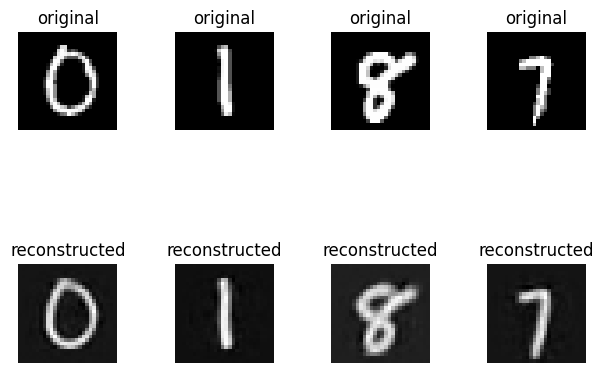

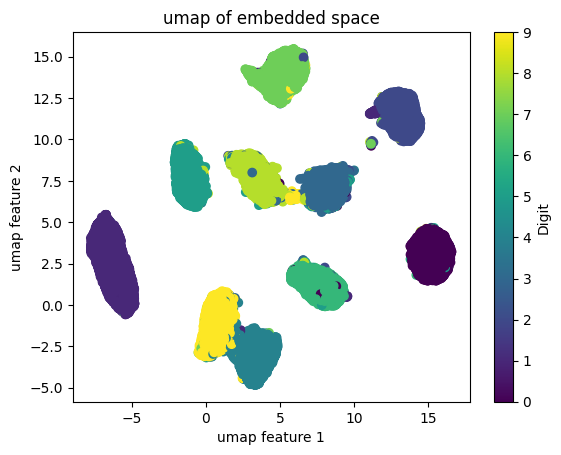

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


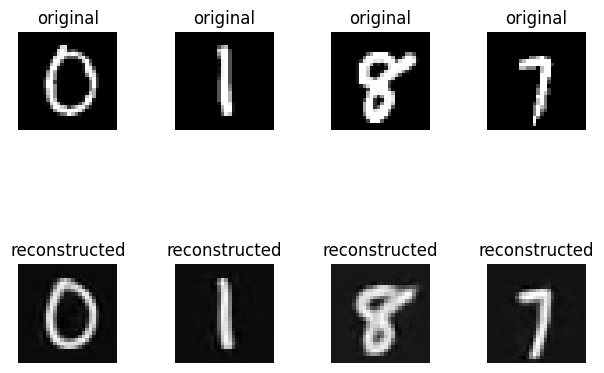

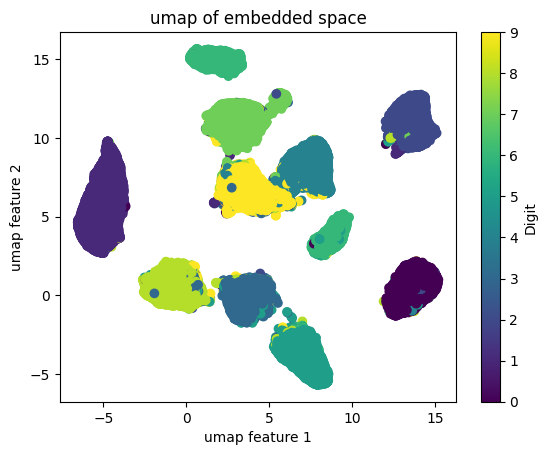

fitted umap


(None, None)

In [4]:
dataset = get_dataset(DatasetType.MNIST)
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_autoencoder_10_pretrained_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

##### USPS

Autoencoder parameters loaded from file.
fitting umap


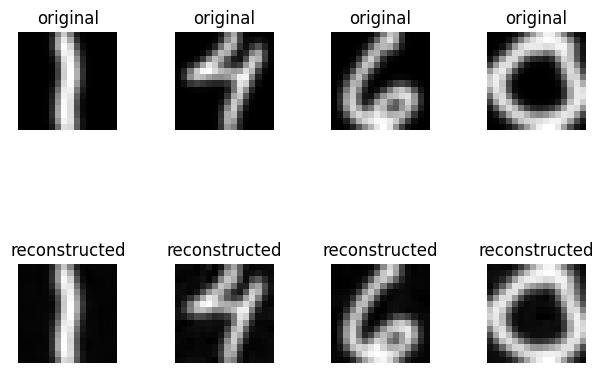

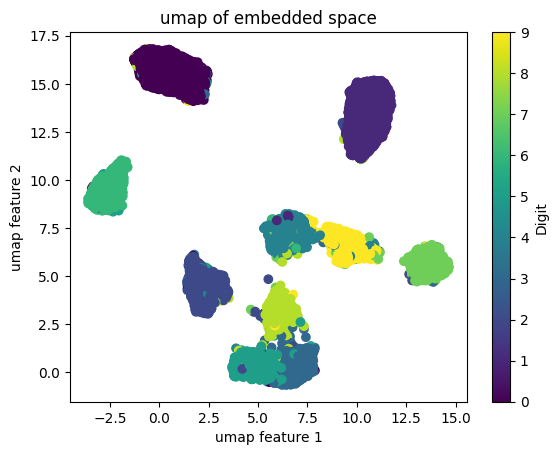

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


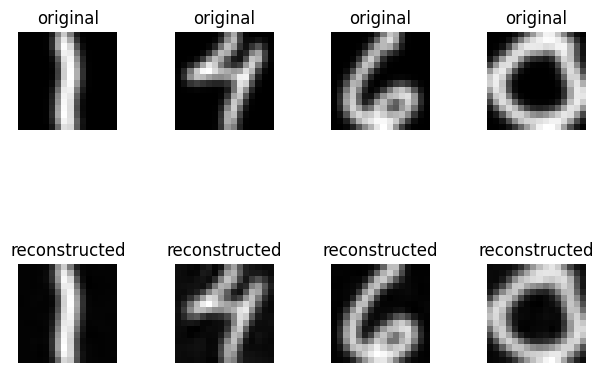

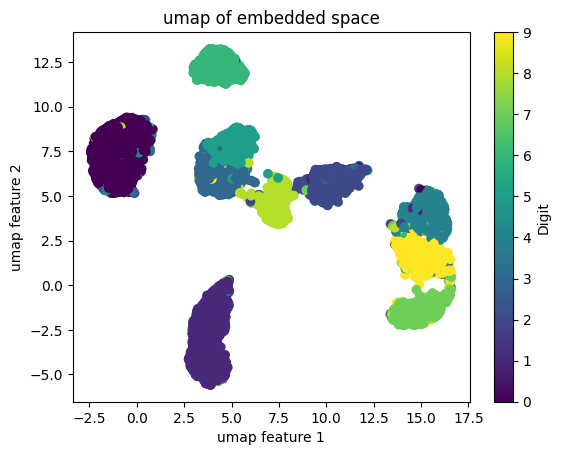

fitted umap


In [5]:
dataset = get_dataset(DatasetType.USPS)
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_autoencoder_10_pretrained_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (16, 16),
    4,
    seed=21,
), 
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (16, 16),
    4,
    seed=21,
)

##### FMNIST

Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


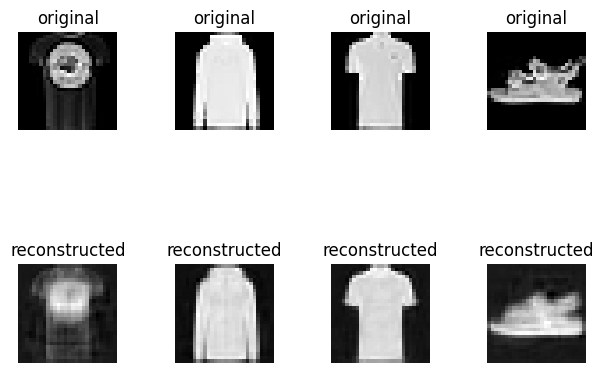

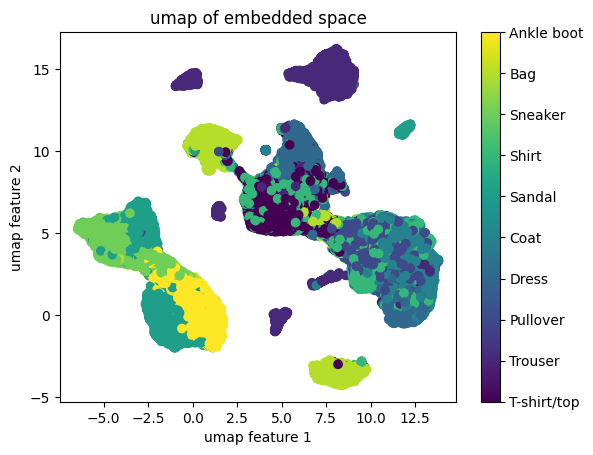

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


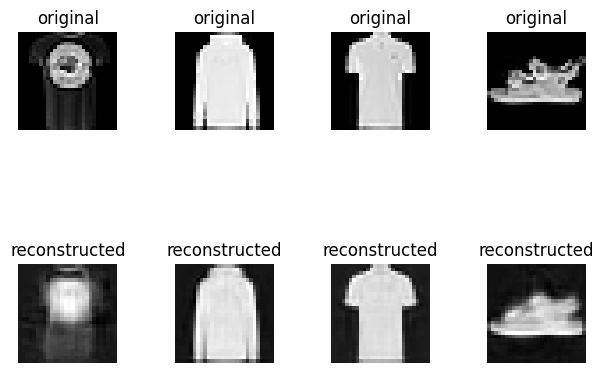

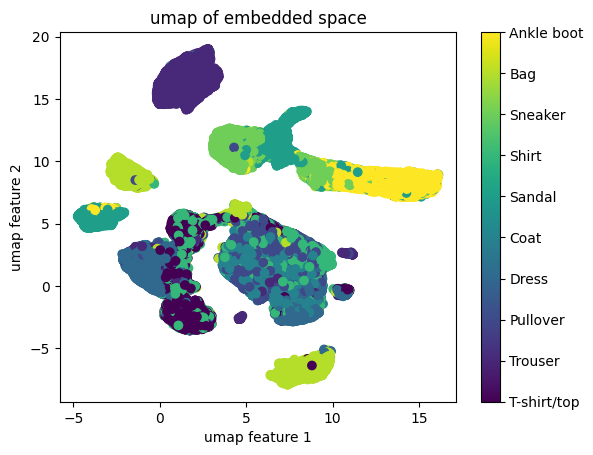

fitted umap


(None, None)

In [6]:
dataset = get_dataset(DatasetType.FASHION_MNIST)
data = dataset["data"] 
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_10_pretrained_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

## Visualization of augmented data

In [12]:
def show_augmented_data(data: np.ndarray, dataset_type: DatasetType, image_size: tuple, number_samples: int):

    (trainloader, _) = get_custom_dataloader_augmentations(data, dataset_type)
    idx, M, M_aug = next(iter(trainloader))

    print(torch.max(M_aug))
    print(torch.min(M_aug))

    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(sorted(random.sample(range(M.shape[0]),number_samples))):
        img = M[index]
        img_aug = M_aug[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_aug.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'augmented')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()
        

##### MNIST

tensor(5.1000)
tensor(0.)


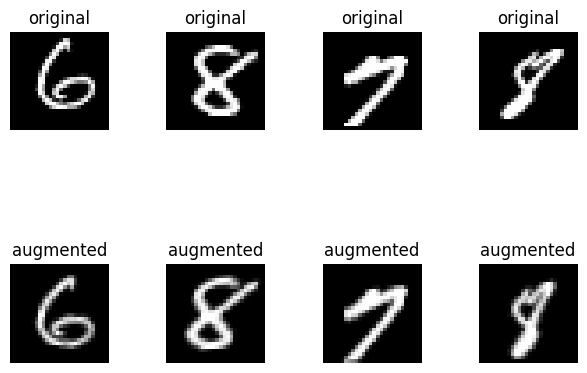

In [13]:
dataset = get_dataset(DatasetType.MNIST)
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.MNIST, (28, 28), 4)

##### USPS

tensor(1.)
tensor(-1.0000)


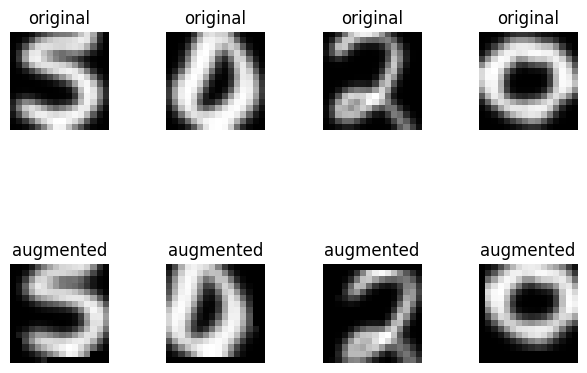

In [14]:
dataset = get_dataset(DatasetType.USPS)
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.USPS, (16, 16), 4)

##### FMNIST

tensor(1.)
tensor(0.)


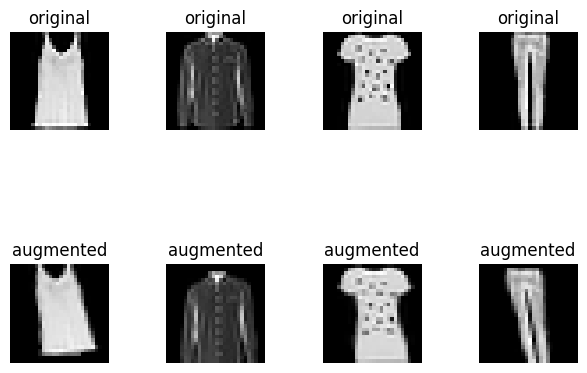

In [17]:
dataset = get_dataset(DatasetType.FASHION_MNIST)
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.FASHION_MNIST, (28,28), 4)

# Visualization of DeepECT Cluster Tree

In [ ]:
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_dataset
import practical.DeepClustering.DeepECT.deepect_paper as deepect_paper
def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, dataset_type):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
    
        center = torch.from_numpy(np.expand_dims(node.center, axis=0))
        
        image = autoencoder.decode(center).detach().numpy()
        # normalize to [0,1] for plotting
        image = minmax_scale(image, feature_range=(0, 1), axis=1)
        
        if dataset_type == DatasetType.USPS:
            image = image.reshape(16,16)
        else:
            image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1.4, cmap="gray")
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

def visualize_cluster_tree(dataset_type: DatasetType, autoencoder_type: AutoencoderType):
    dataset = get_dataset(dataset_type)

    data = dataset["data"]
    labels = dataset["target"]

    autoencoder = pretraining(autoencoder_type, None, dataset, 42, 10)

    deepect = deepect_paper.DeepECT(
        autoencoder=autoencoder,
        clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
        max_leaf_nodes=20,
        random_state=np.random.RandomState(42),
    )

    deepect.fit_predict(data)

    print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

    build_and_visualize_tree(deepect.tree_.root, autoencoder, dataset_type)

cpu


Fit:   1%|          | 503/50000 [00:35<10:55:26,  1.26it/s]

Leaf assignments: 48732
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:18<11:34:03,  1.18it/s]

Leaf assignments: 30922
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:53<8:02:20,  1.68it/s] 

Leaf assignments: 20642
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2001/50000 [02:30<13:41:09,  1.03s/it]

Leaf assignments: 15744
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2503/50000 [03:09<8:05:38,  1.63it/s] 

Leaf assignments: 18325
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3003/50000 [03:45<7:48:57,  1.67it/s] 

Leaf assignments: 12913
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [04:22<8:05:38,  1.60it/s] 

Leaf assignments: 9879
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [04:59<7:56:07,  1.61it/s] 

Leaf assignments: 12646
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4502/50000 [05:41<14:23:08,  1.14s/it]

Leaf assignments: 5861
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5001/50000 [06:27<13:58:02,  1.12s/it]

Leaf assignments: 6452
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5501/50000 [07:14<14:01:26,  1.13s/it]

Leaf assignments: 7400
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6001/50000 [08:02<16:06:46,  1.32s/it]

Leaf assignments: 7024
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6502/50000 [08:51<13:26:08,  1.11s/it]

Leaf assignments: 6431
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [09:38<13:47:11,  1.15s/it]

Leaf assignments: 6723
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7501/50000 [10:25<13:12:17,  1.12s/it]

Leaf assignments: 5638
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8002/50000 [11:13<13:09:13,  1.13s/it]

Leaf assignments: 5091
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8501/50000 [12:00<12:56:47,  1.12s/it]

Leaf assignments: 6616
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [12:45<9:55:29,  1.15it/s] 

Leaf assignments: 9065
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 97.10it/s]


Accuracy:  0.8468571428571429


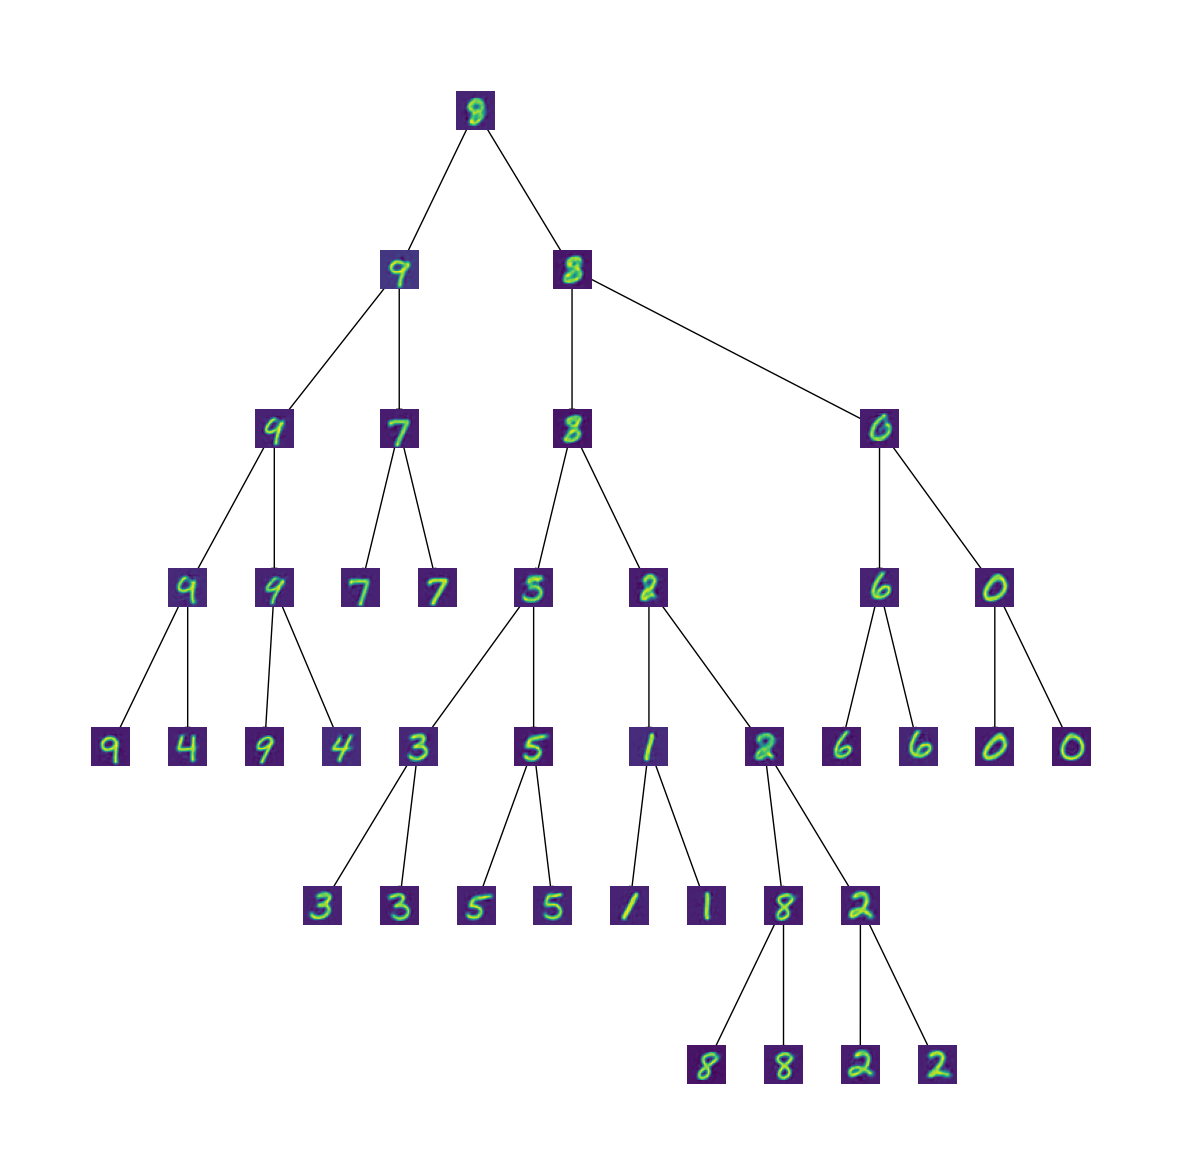

In [ ]:
visualize_cluster_tree(
    DatasetType.MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.MNIST, AutoencoderType.DEEPECT_STACKED_AE)

#### Visualize embedded space after DeepECT

Autoencoder parameters loaded from file.
fitting pca


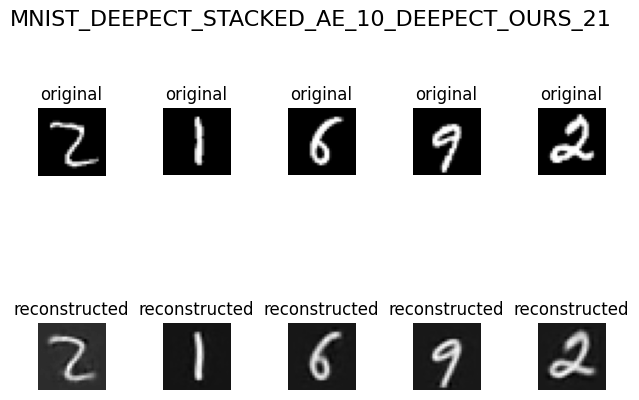

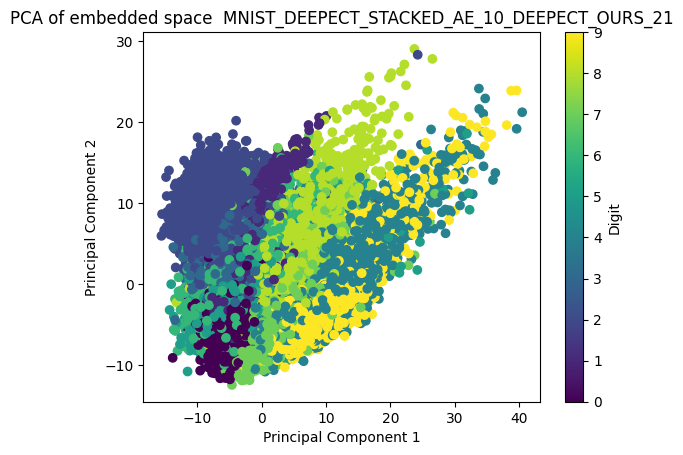

fitted pca
fitting umap


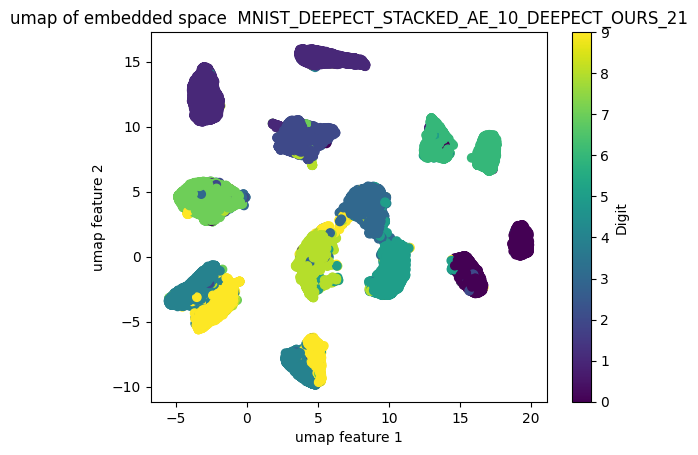

fitted umap
Autoencoder parameters loaded from file.
fitting pca


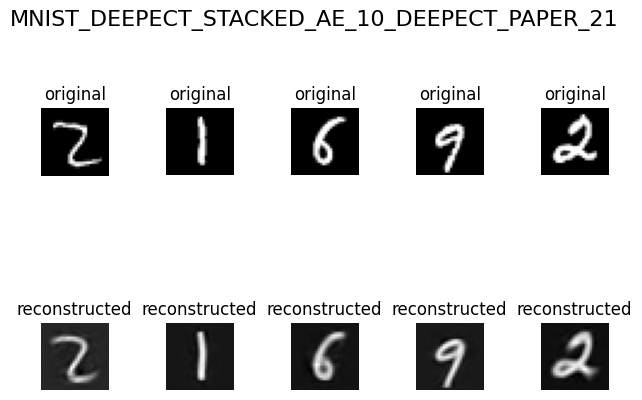

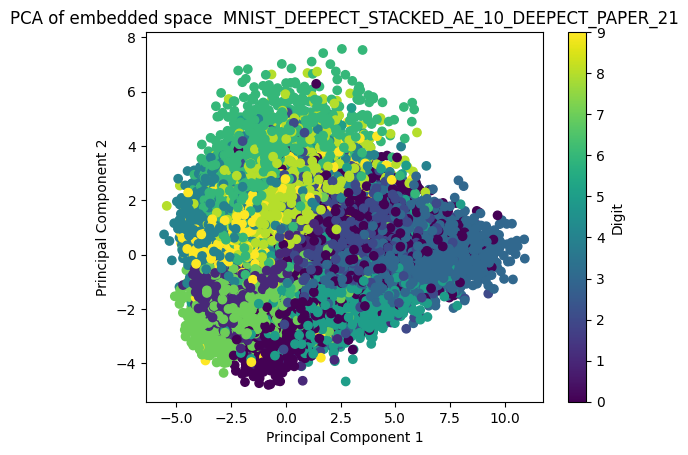

fitted pca
fitting umap


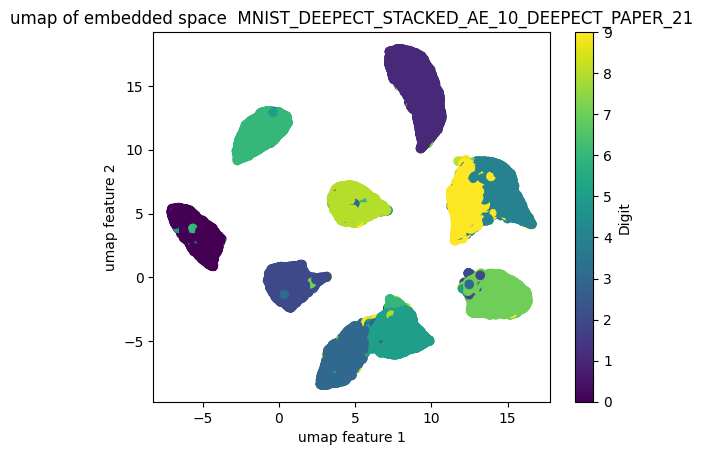

fitted umap
Autoencoder parameters loaded from file.
fitting pca


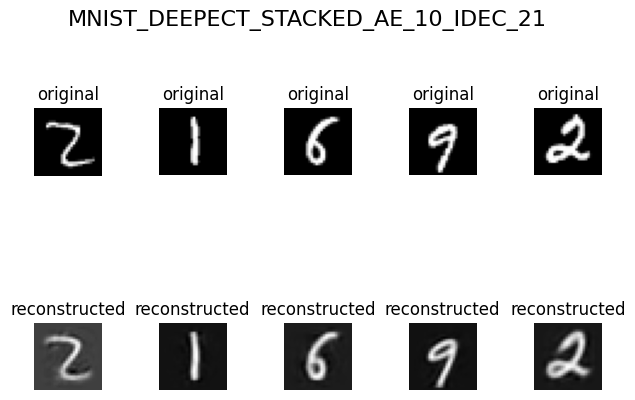

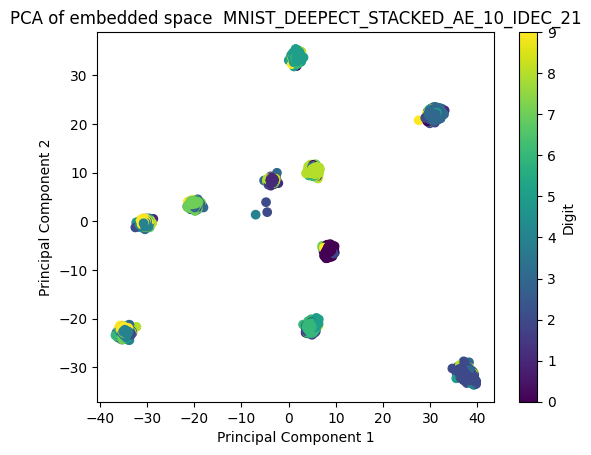

fitted pca
fitting umap


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


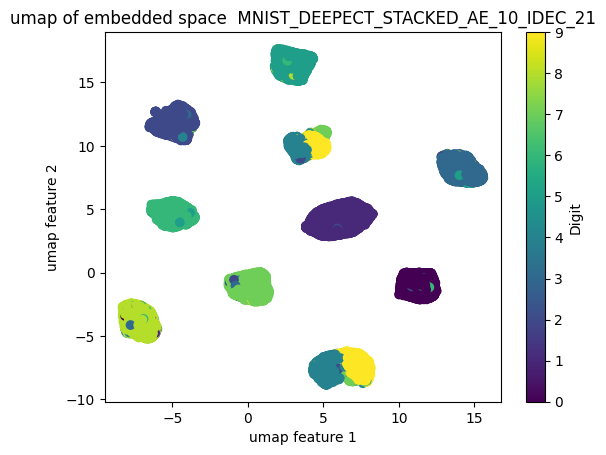

fitted umap


In [8]:
visualize_perfomance_multiple_AE(
    [DatasetType.MNIST]*5, 
    [
        "practical/DeepClustering/DeepECT/MNIST_DEEPECT_STACKED_AE_10_DEEPECT_OURS_21.pth",
        "practical/DeepClustering/DeepECT/MNIST_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.pth",
        "practical/DeepClustering/DeepECT/MNIST_DEEPECT_STACKED_AE_10_IDEC_21.pth"
    ],
    [AutoencoderType.DEEPECT_STACKED_AE]*5, 
)

Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


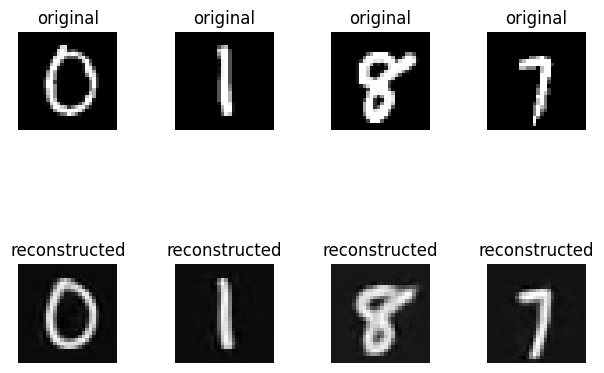

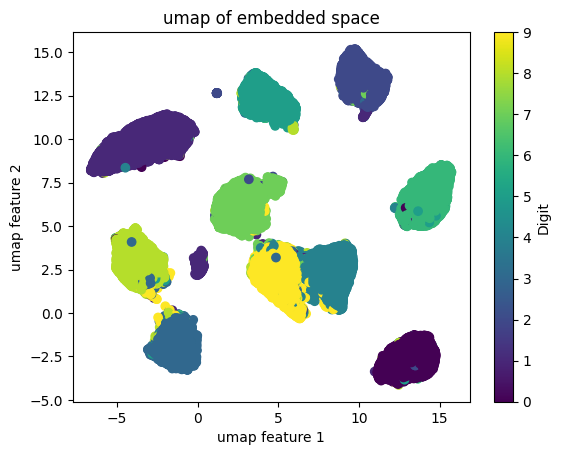

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


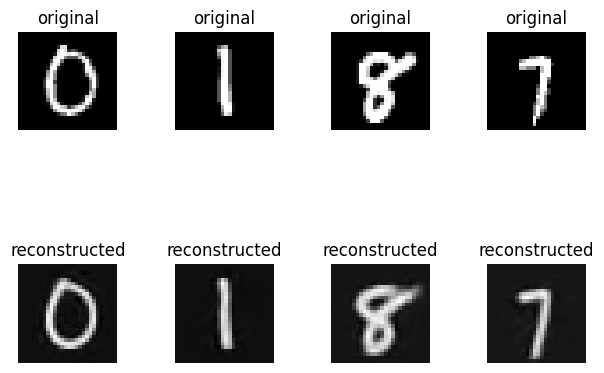

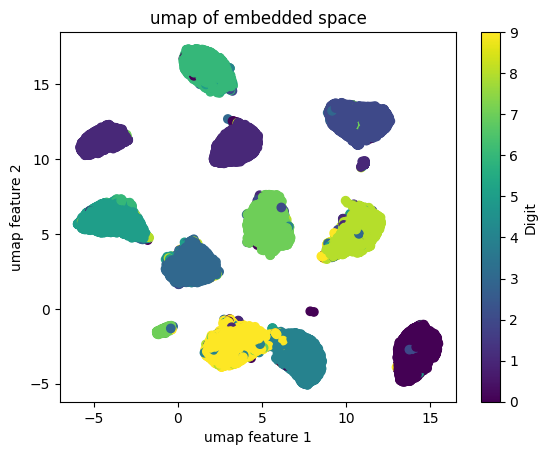

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


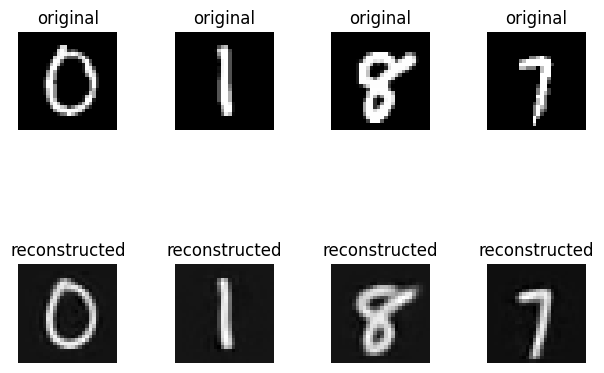

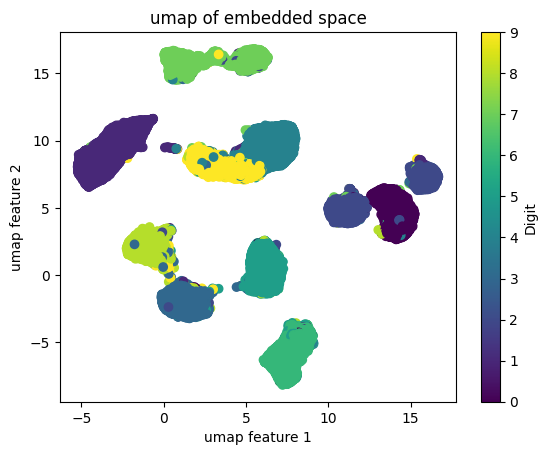

fitted umap


(None, None, None)

In [27]:
dataset = get_dataset(DatasetType.MNIST)
data = dataset["data"]
labels = dataset["target"]

visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/MNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_PAPER_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/MNIST_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

cpu


Fit:   1%|          | 503/50000 [00:37<8:45:16,  1.57it/s] 

Leaf assignments: 46556
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:11<10:59:45,  1.24it/s]

Leaf assignments: 22235
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:45<7:51:44,  1.71it/s] 

Leaf assignments: 22339
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2002/50000 [02:18<10:41:53,  1.25it/s]

Leaf assignments: 24994
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2502/50000 [02:52<10:12:04,  1.29it/s]

Leaf assignments: 16038
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [03:25<10:36:04,  1.23it/s]

Leaf assignments: 5087
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:58<7:26:24,  1.74it/s] 

Leaf assignments: 17650
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4002/50000 [04:30<8:45:13,  1.46it/s]

Leaf assignments: 6445
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [05:03<7:17:10,  1.73it/s] 

Leaf assignments: 9463
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [05:36<9:57:23,  1.26it/s]

Leaf assignments: 6257
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [06:14<7:53:33,  1.57it/s] 

Leaf assignments: 15138
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6002/50000 [06:47<9:29:19,  1.29it/s]

Leaf assignments: 8488
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [07:20<6:49:14,  1.77it/s]

Leaf assignments: 2859
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [13:30<612:26:29, 51.28s/it]

Leaf assignments: 6366
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [14:18<9:37:44,  1.23it/s]  

Leaf assignments: 2711
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [14:53<6:33:03,  1.78it/s]

Leaf assignments: 5536
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [15:29<6:43:01,  1.72it/s]

Leaf assignments: 2567
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9003/50000 [16:02<6:31:27,  1.75it/s]

Leaf assignments: 2414
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 114.17it/s]


Accuracy:  0.5767428571428571


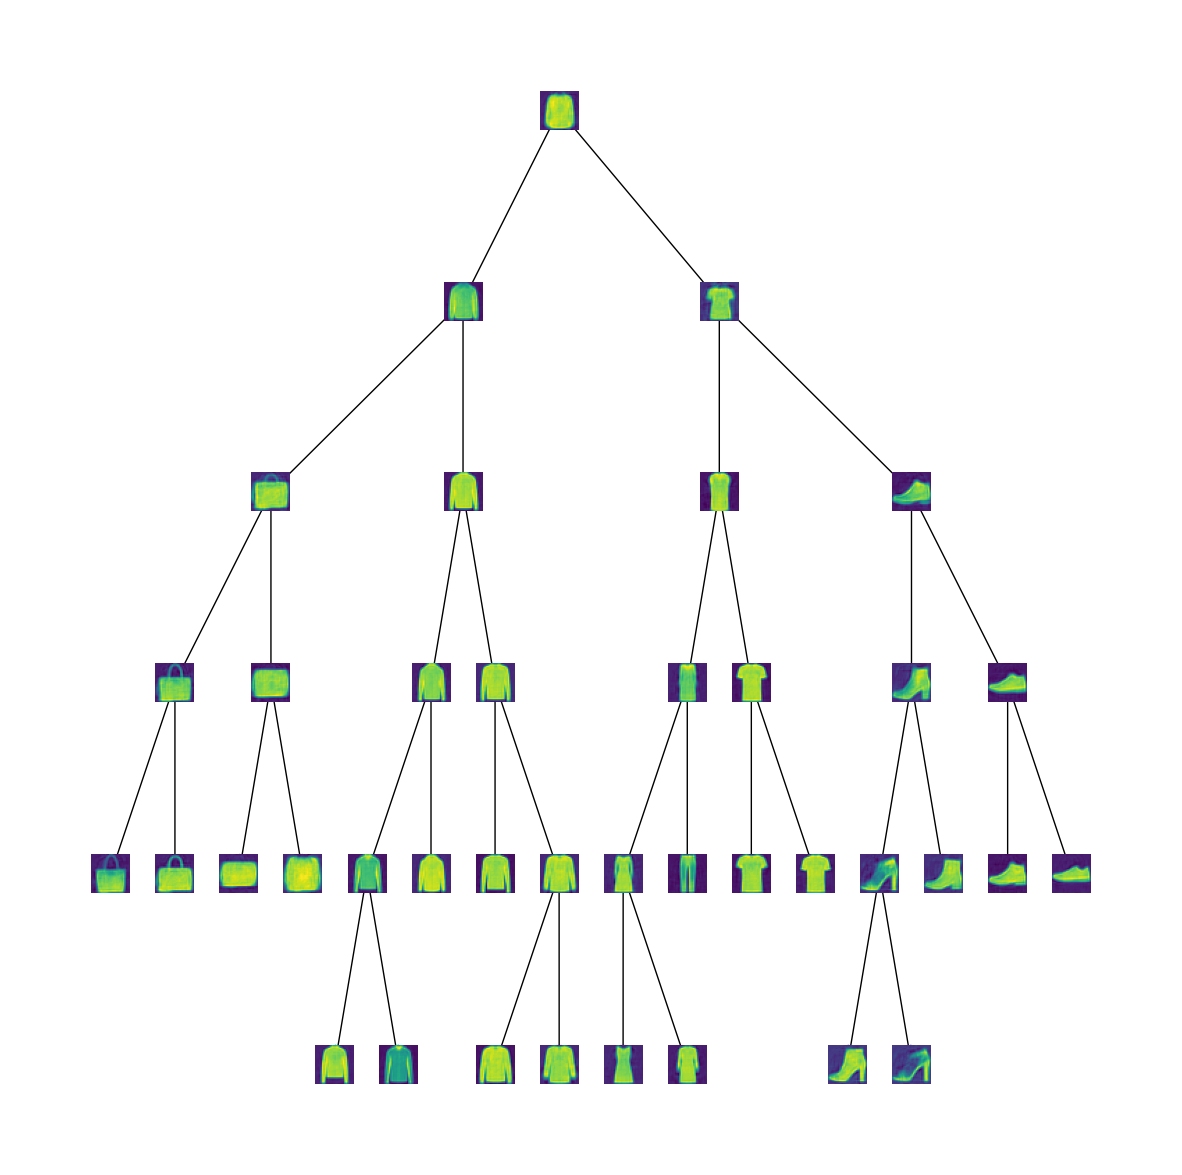

In [ ]:
visualize_cluster_tree(
    DatasetType.FASHION_MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.FASHION_MNIST, AutoencoderType.DEEPECT_STACKED_AE)

#### Visualize embedded space after DeepECT

Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


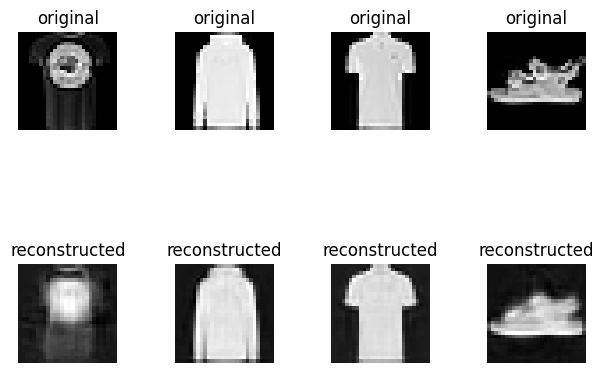

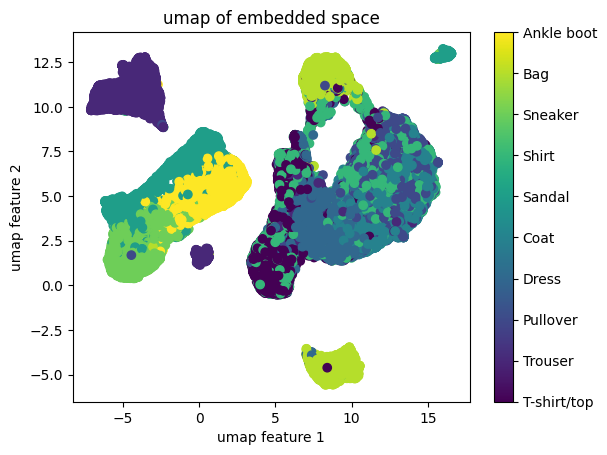

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


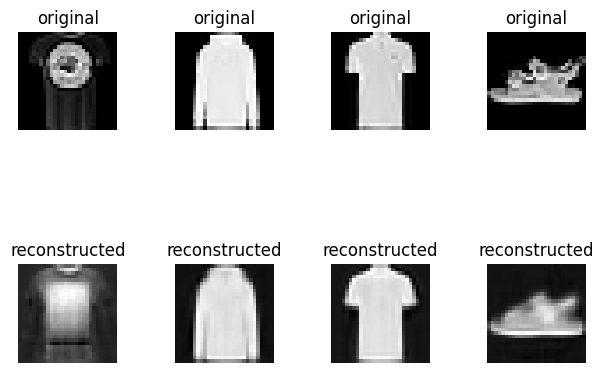

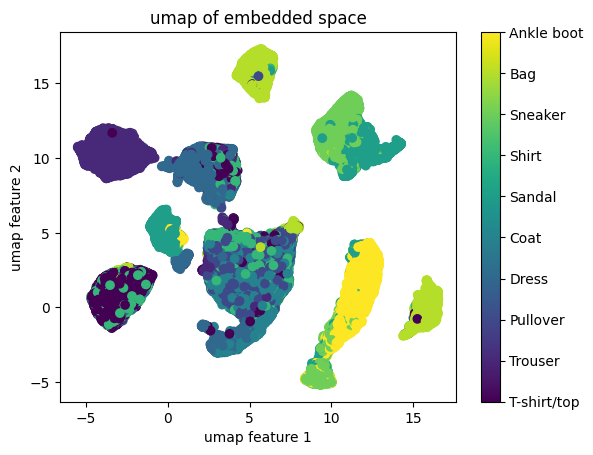

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


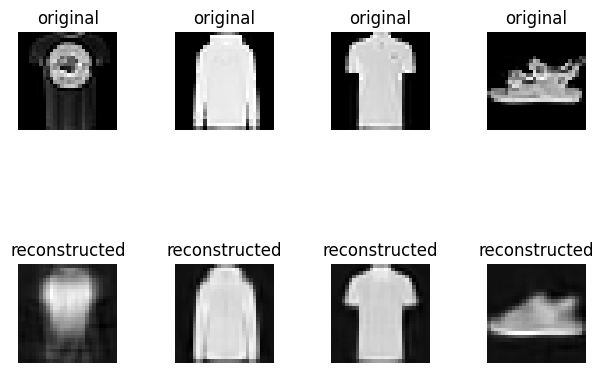

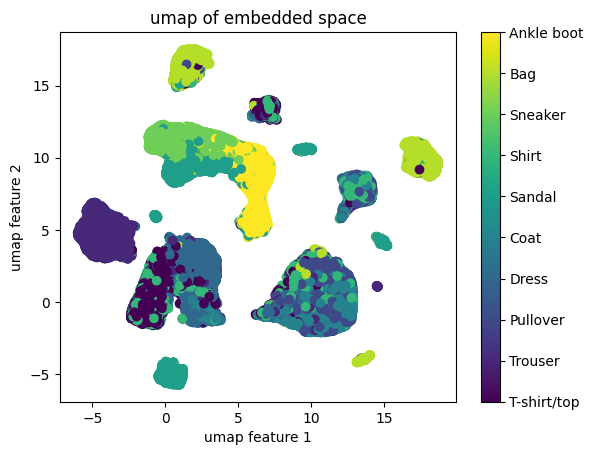

fitted umap


In [30]:
dataset = get_dataset(DatasetType.FASHION_MNIST)
data = dataset["data"] 
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
),
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
),
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_PAPER_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


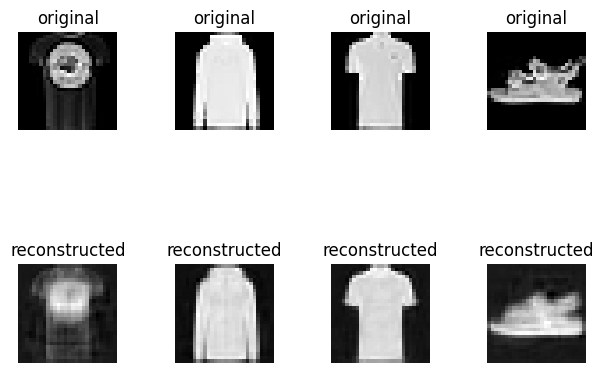

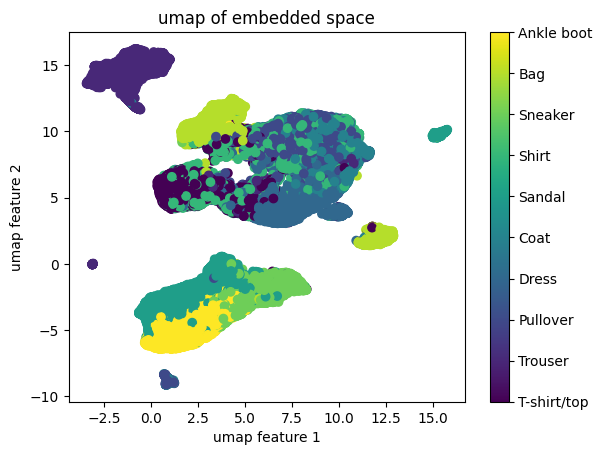

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


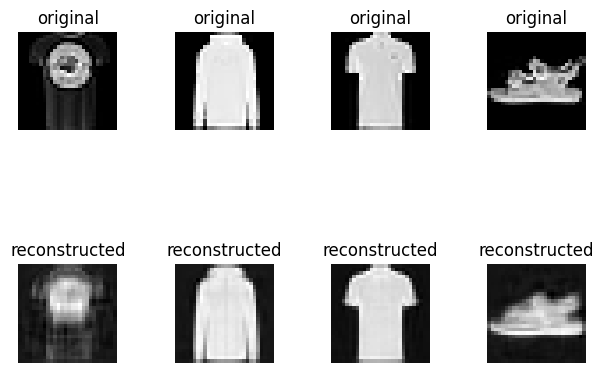

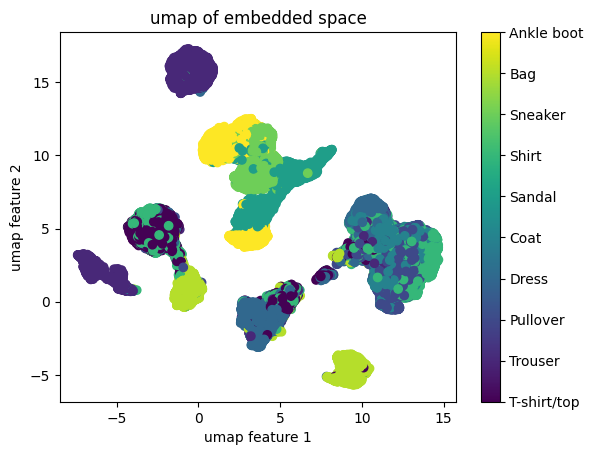

fitted umap
Autoencoder parameters loaded from file.
fitting umap


/home/loebbert/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


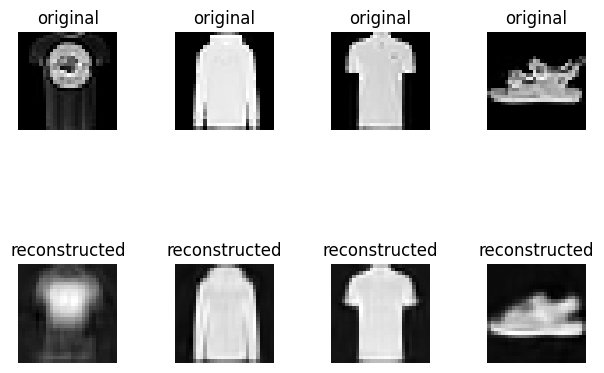

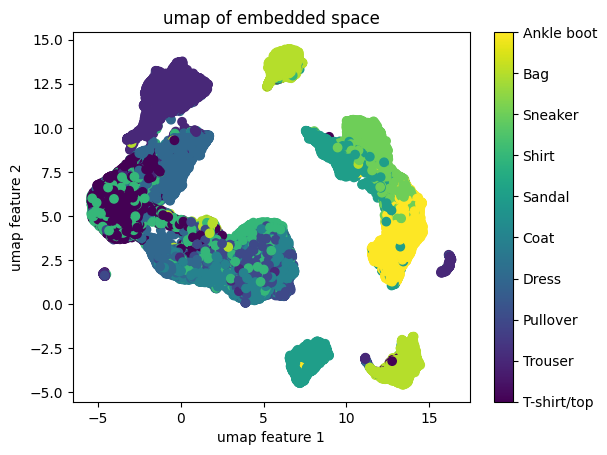

fitted umap


In [32]:
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_10_pretrained_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
),
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
),
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
)

cpu


Fit:   1%|          | 504/50000 [00:27<1:21:10, 10.16it/s]

Leaf assignments: 3673
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1003/50000 [00:52<1:20:40, 10.12it/s]

Leaf assignments: 5678
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:17<1:18:44, 10.26it/s]

Leaf assignments: 4542
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2003/50000 [01:43<1:27:22,  9.16it/s]

Leaf assignments: 2270
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2504/50000 [02:08<1:18:44, 10.05it/s]

Leaf assignments: 1531
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [02:35<1:30:42,  8.64it/s]

Leaf assignments: 2101
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:03<1:34:40,  8.19it/s]

Leaf assignments: 785
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [03:31<1:31:32,  8.37it/s]

Leaf assignments: 1037
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [03:59<1:25:33,  8.86it/s]

Leaf assignments: 1349
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [04:27<2:04:26,  6.03it/s]

Leaf assignments: 671
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [04:56<1:34:26,  7.85it/s]

Leaf assignments: 967
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6003/50000 [05:27<1:37:35,  7.51it/s]

Leaf assignments: 866
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [05:57<1:28:44,  8.17it/s]

Leaf assignments: 1173
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7003/50000 [06:25<1:26:38,  8.27it/s]

Leaf assignments: 657
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [06:54<1:47:55,  6.56it/s]

Leaf assignments: 405
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [07:24<1:38:16,  7.12it/s]

Leaf assignments: 388
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [07:53<1:27:17,  7.92it/s]

Leaf assignments: 457
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [08:22<1:43:20,  6.61it/s]

Leaf assignments: 729
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 37/37 [00:00<00:00, 110.28it/s]


Accuracy:  0.6300279630027963


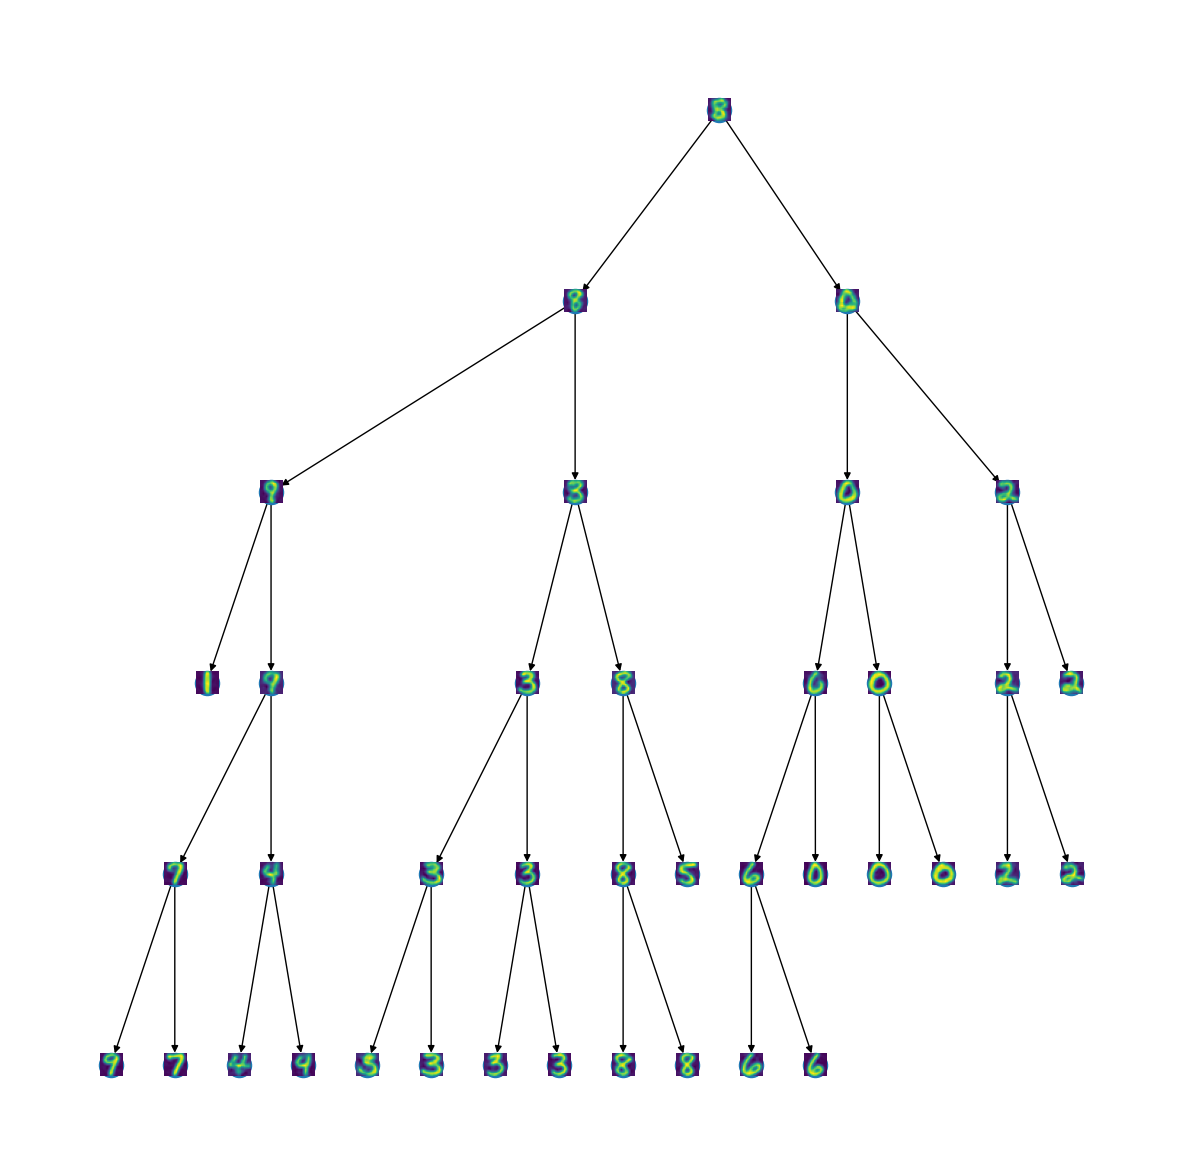

In [ ]:
visualize_cluster_tree(
    DatasetType.USPS, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.USPS, AutoencoderType.DEEPECT_STACKED_AE)

# Loss and Accuracy Visualization

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def read_log_file(log_file, augmented=False):
    if augmented:
        pattern = re.compile(r'INFO:root:(\d+) - moving averages: dc_loss: ([\d.]+) nc_loss: ([\d.]+) rec_loss: ([\d.]+) rec_loss_aug: ([\d.]+) total_loss: ([\d.]+) nodes: (\d+) leaf_nodes: (\d+)')
    else:
        pattern = re.compile(r'INFO:root:(\d+) - moving averages: dc_loss: ([\d.]+) nc_loss: ([\d.]+) rec_loss: ([\d.]+)  total_loss: ([\d.]+) nodes: (\d+) leaf_nodes: (\d+)')
    
    data = {'epoch': [], 'dc_loss': [], 'nc_loss': [], 'rec_loss': [], 'rec_loss_aug': [], 'total_loss': [], 'nodes': [], 'leaf_nodes': []}

    with open(log_file, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                if augmented:
                    epoch, dc_loss, nc_loss, rec_loss, rec_loss_aug, total_loss, nodes, leaf_nodes = match.groups()
                    data['rec_loss_aug'].append(float(rec_loss_aug))
                else:
                    epoch, dc_loss, nc_loss, rec_loss, total_loss, nodes, leaf_nodes = match.groups()
                    data['rec_loss_aug'].append(None)
                data['epoch'].append(int(epoch))
                data['dc_loss'].append(float(dc_loss))
                data['nc_loss'].append(float(nc_loss))
                data['rec_loss'].append(float(rec_loss))
                data['total_loss'].append(float(total_loss))
                data['nodes'].append(int(nodes))
                data['leaf_nodes'].append(int(leaf_nodes))

    df = pd.DataFrame(data)
    return df

In [108]:
from practical.DeepClustering.DeepECT.metrics_visualization import plot_accuracy_comparison, plot_comparison

##  MNIST

#### Standard

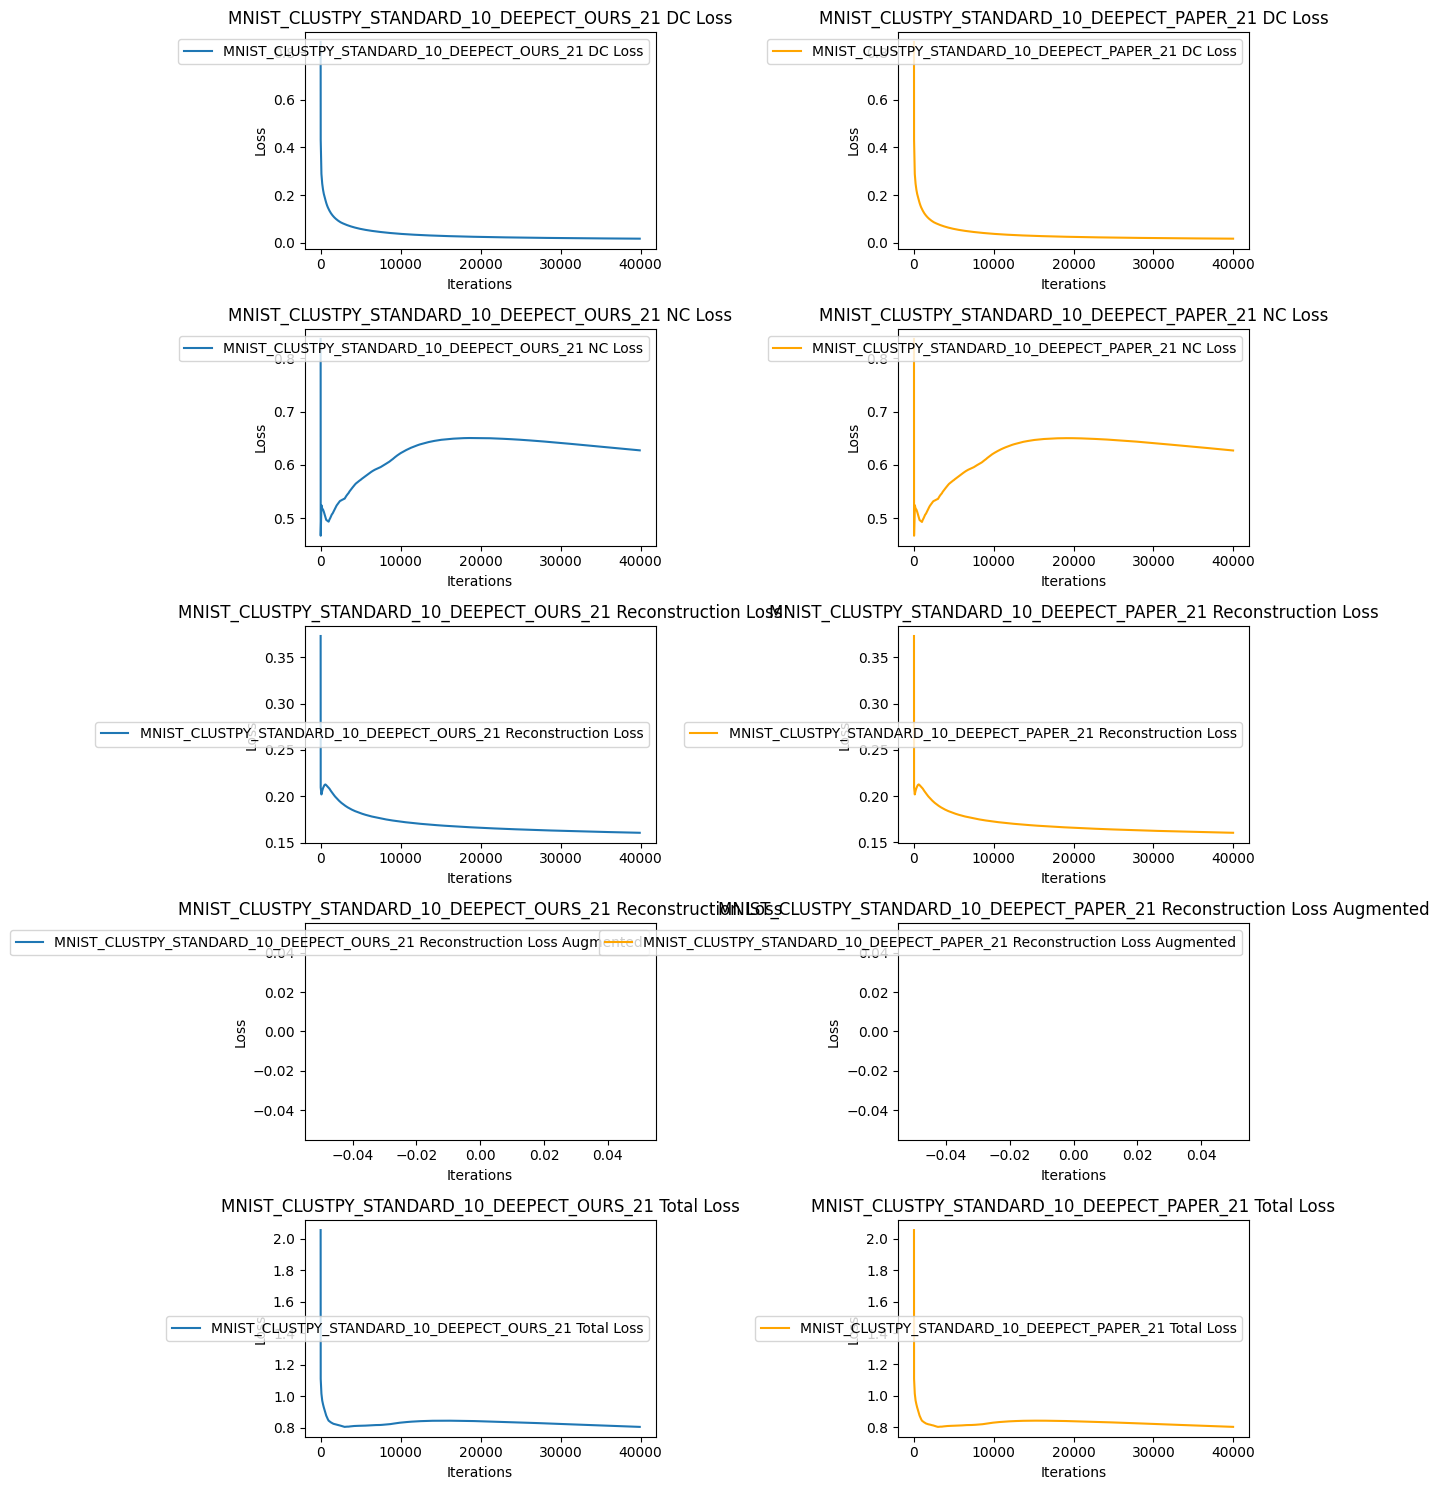

(None,)

In [115]:
plot_comparison(
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_OURS_21.txt",
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.txt",
), 
# plot_comparison(
#     "practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_OURS_42.txt",
#     "practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_42.txt",
# )

#### Stacked Autoencoder

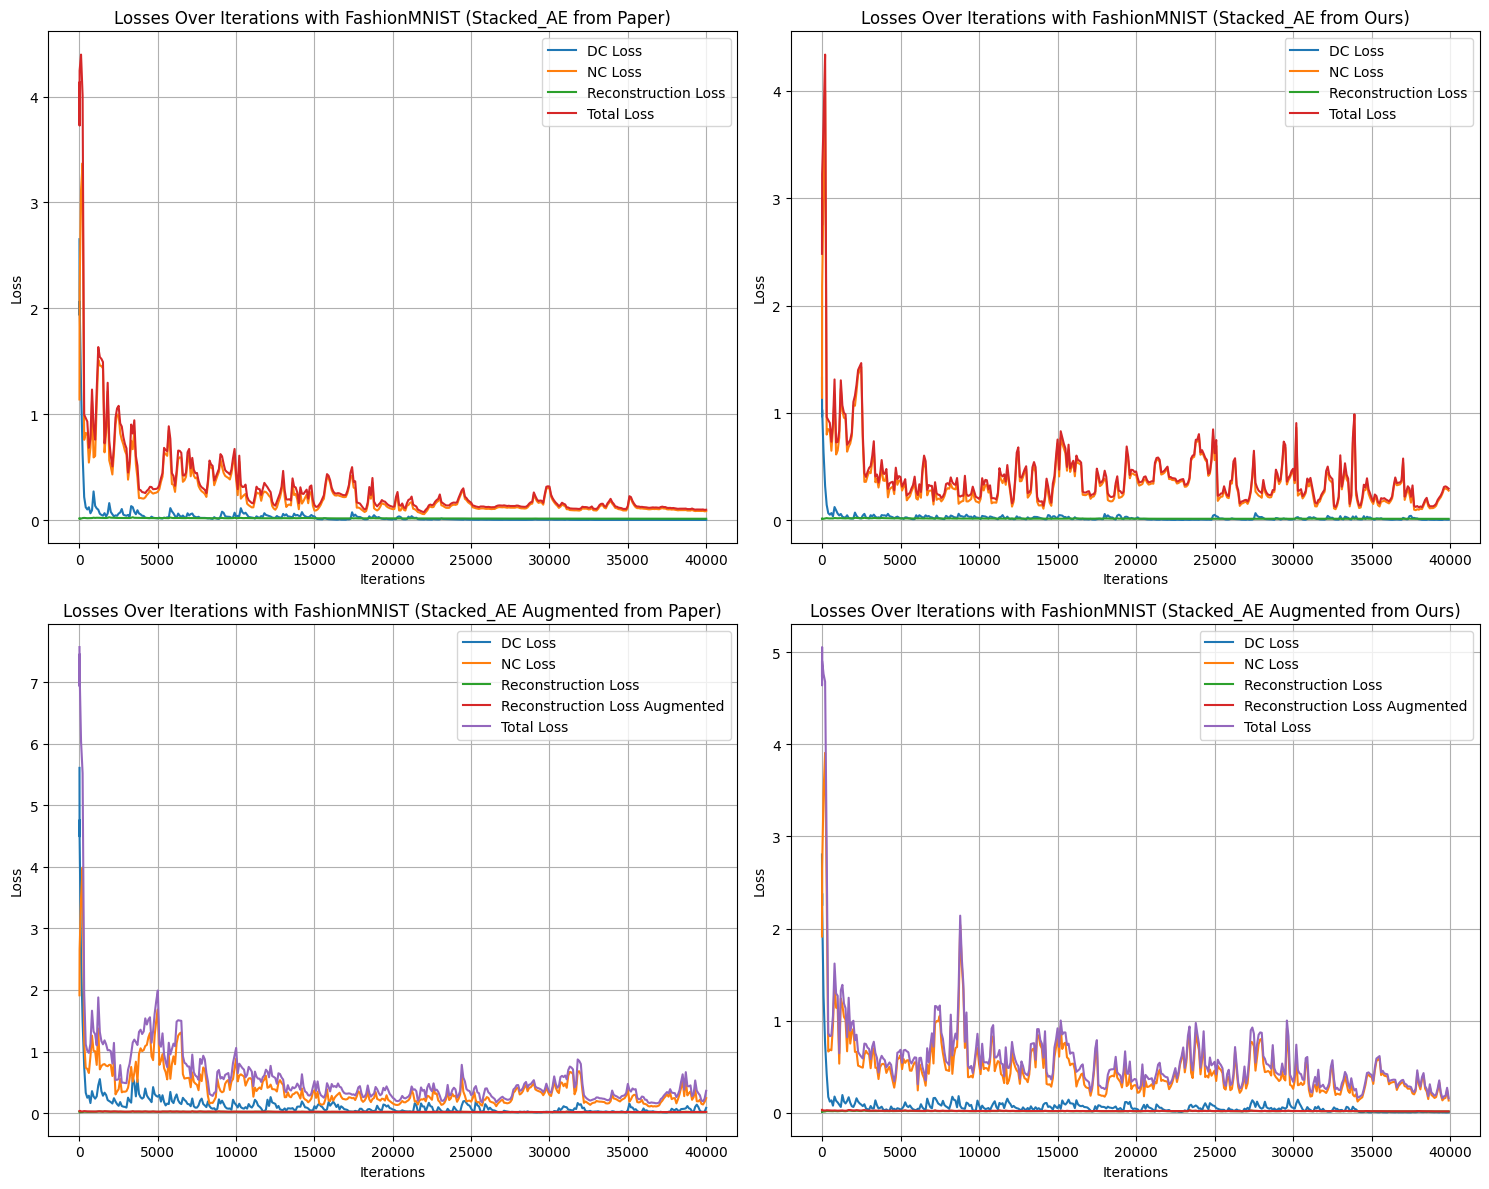

In [12]:
log_file_1 = 'practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.txt'
log_file_2 = 'practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_OURS_21.txt'
log_file_3 = 'practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_PAPER_21.txt'
log_file_4 = 'practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_OURS_21.txt'

df1 = read_log_file(log_file_1, augmented=False)
df2 = read_log_file(log_file_2, augmented=False)
df3 = read_log_file(log_file_3, augmented=True)
df4 = read_log_file(log_file_4, augmented=True)

def plot_losses(ax, df, title):
    if not df.empty:
        ax.plot(df['epoch'], df['dc_loss'], label='DC Loss')
        ax.plot(df['epoch'], df['nc_loss'], label='NC Loss')
        ax.plot(df['epoch'], df['rec_loss'], label='Reconstruction Loss')
        if df['rec_loss_aug'].notna().any():
            ax.plot(df['epoch'], df['rec_loss_aug'], label='Reconstruction Loss Augmented')
        ax.plot(df['epoch'], df['total_loss'], label='Total Loss')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    else:
        ax.set_title(f"No data to plot for {title}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_losses(axes[0, 0], df1, 'Losses Over Iterations with FashionMNIST (Stacked_AE from Paper)')
plot_losses(axes[0, 1], df2, 'Losses Over Iterations with FashionMNIST (Stacked_AE from Ours)')
plot_losses(axes[1, 0], df3, 'Losses Over Iterations with FashionMNIST (Stacked_AE Augmented from Paper)')
plot_losses(axes[1, 1], df4, 'Losses Over Iterations with FashionMNIST (Stacked_AE Augmented from Ours)')

# Adjust layout
plt.tight_layout()
plt.show()

#### Nodes Visualization

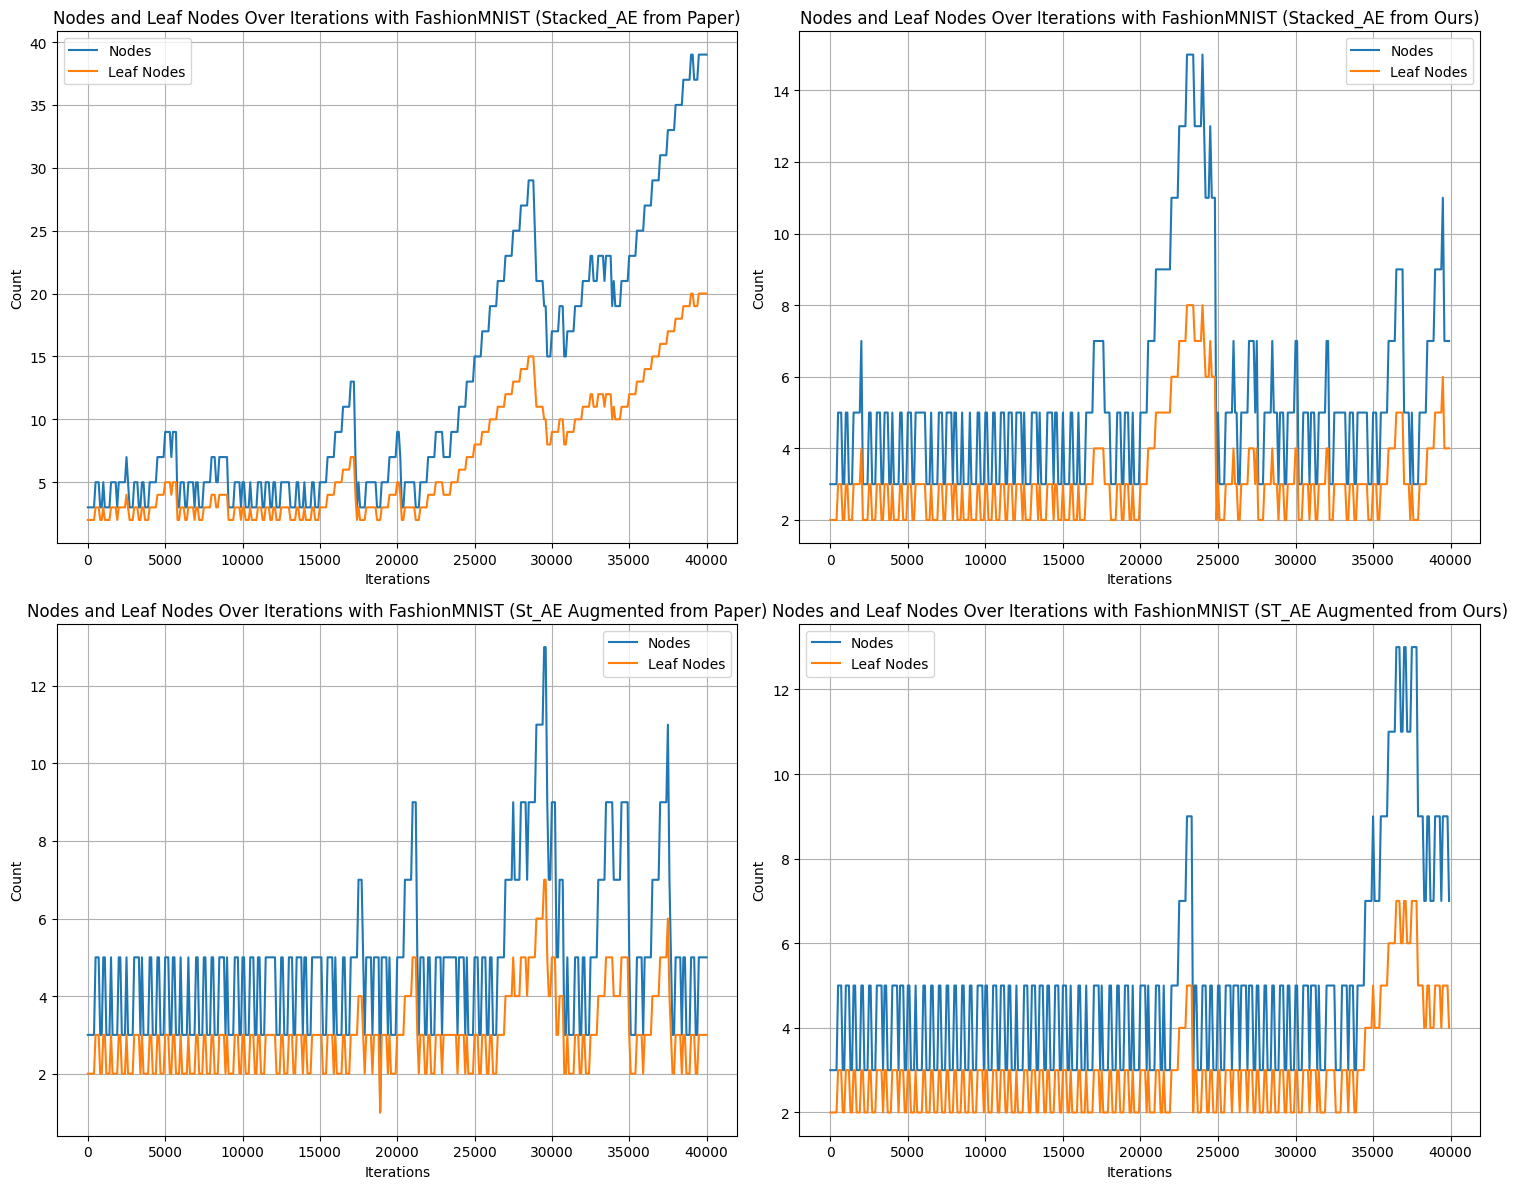

In [15]:
def plot_nodes(ax, df, title):
    if not df.empty:
        ax.plot(df['epoch'], df['nodes'], label='Nodes')
        ax.plot(df['epoch'], df['leaf_nodes'], label='Leaf Nodes')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    else:
        ax.set_title(f"No data to plot for {title}")

# Create subplots for nodes and leaf nodes
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot nodes and leaf nodes for each log file
plot_nodes(axes[0, 0], df1, 'Nodes and Leaf Nodes Over Iterations with FashionMNIST (Stacked_AE from Paper)')
plot_nodes(axes[0, 1], df2, 'Nodes and Leaf Nodes Over Iterations with FashionMNIST (Stacked_AE from Ours)')
plot_nodes(axes[1, 0], df3, 'Nodes and Leaf Nodes Over Iterations with FashionMNIST (St_AE Augmented from Paper)')
plot_nodes(axes[1, 1], df4, 'Nodes and Leaf Nodes Over Iterations with FashionMNIST (ST_AE Augmented from Ours)')

# Adjust layout
plt.tight_layout()
plt.show()

#### Augmentated

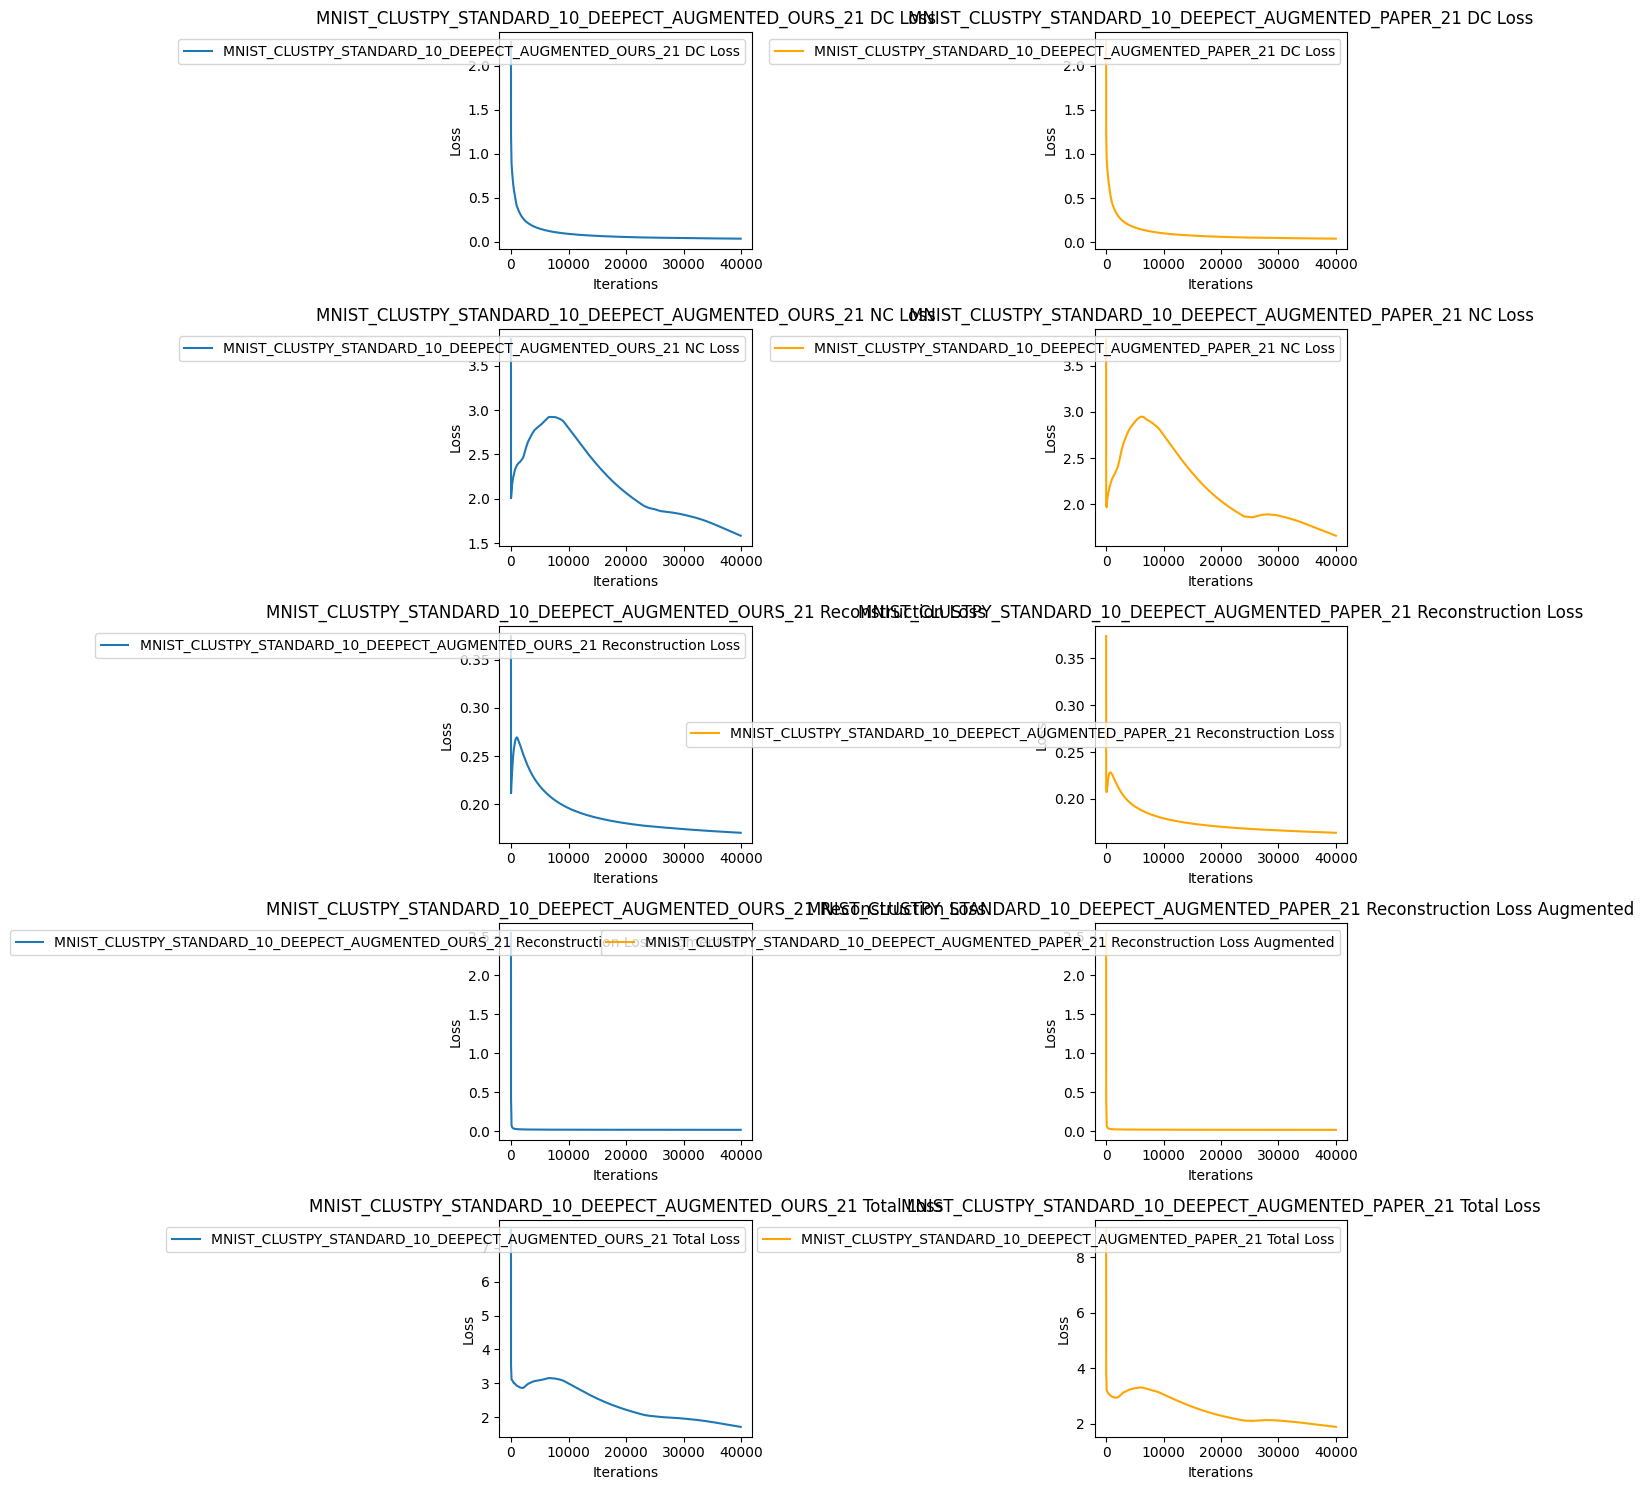

In [138]:
plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.txt')

##  FASHION-MNIST

#### Standard

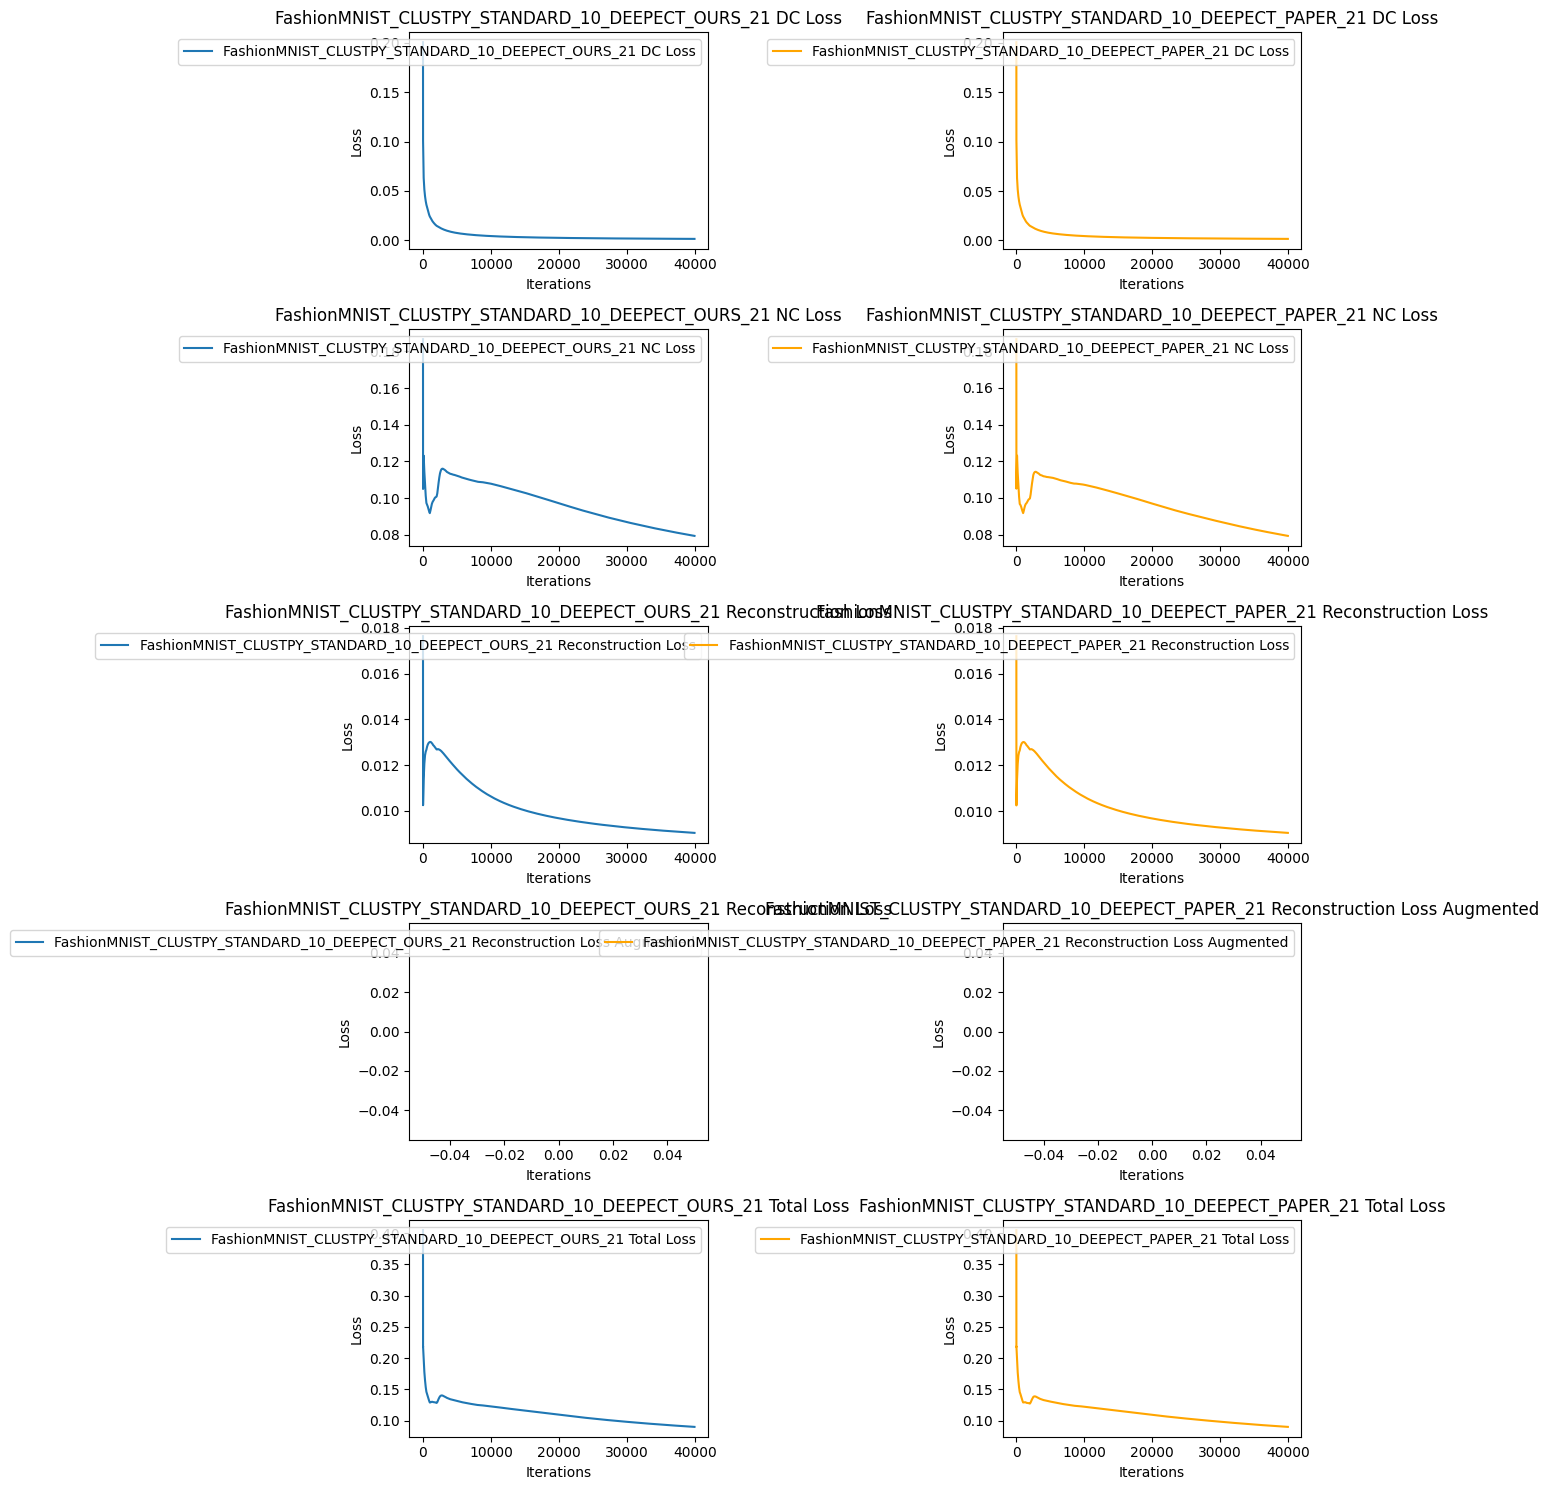

In [40]:
plot_comparison('practical/DeepClustering/DeepECT/results_log/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_OURS_21.txt', 'practical/DeepClustering/DeepECT/results_log/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.txt')

#### Augmented

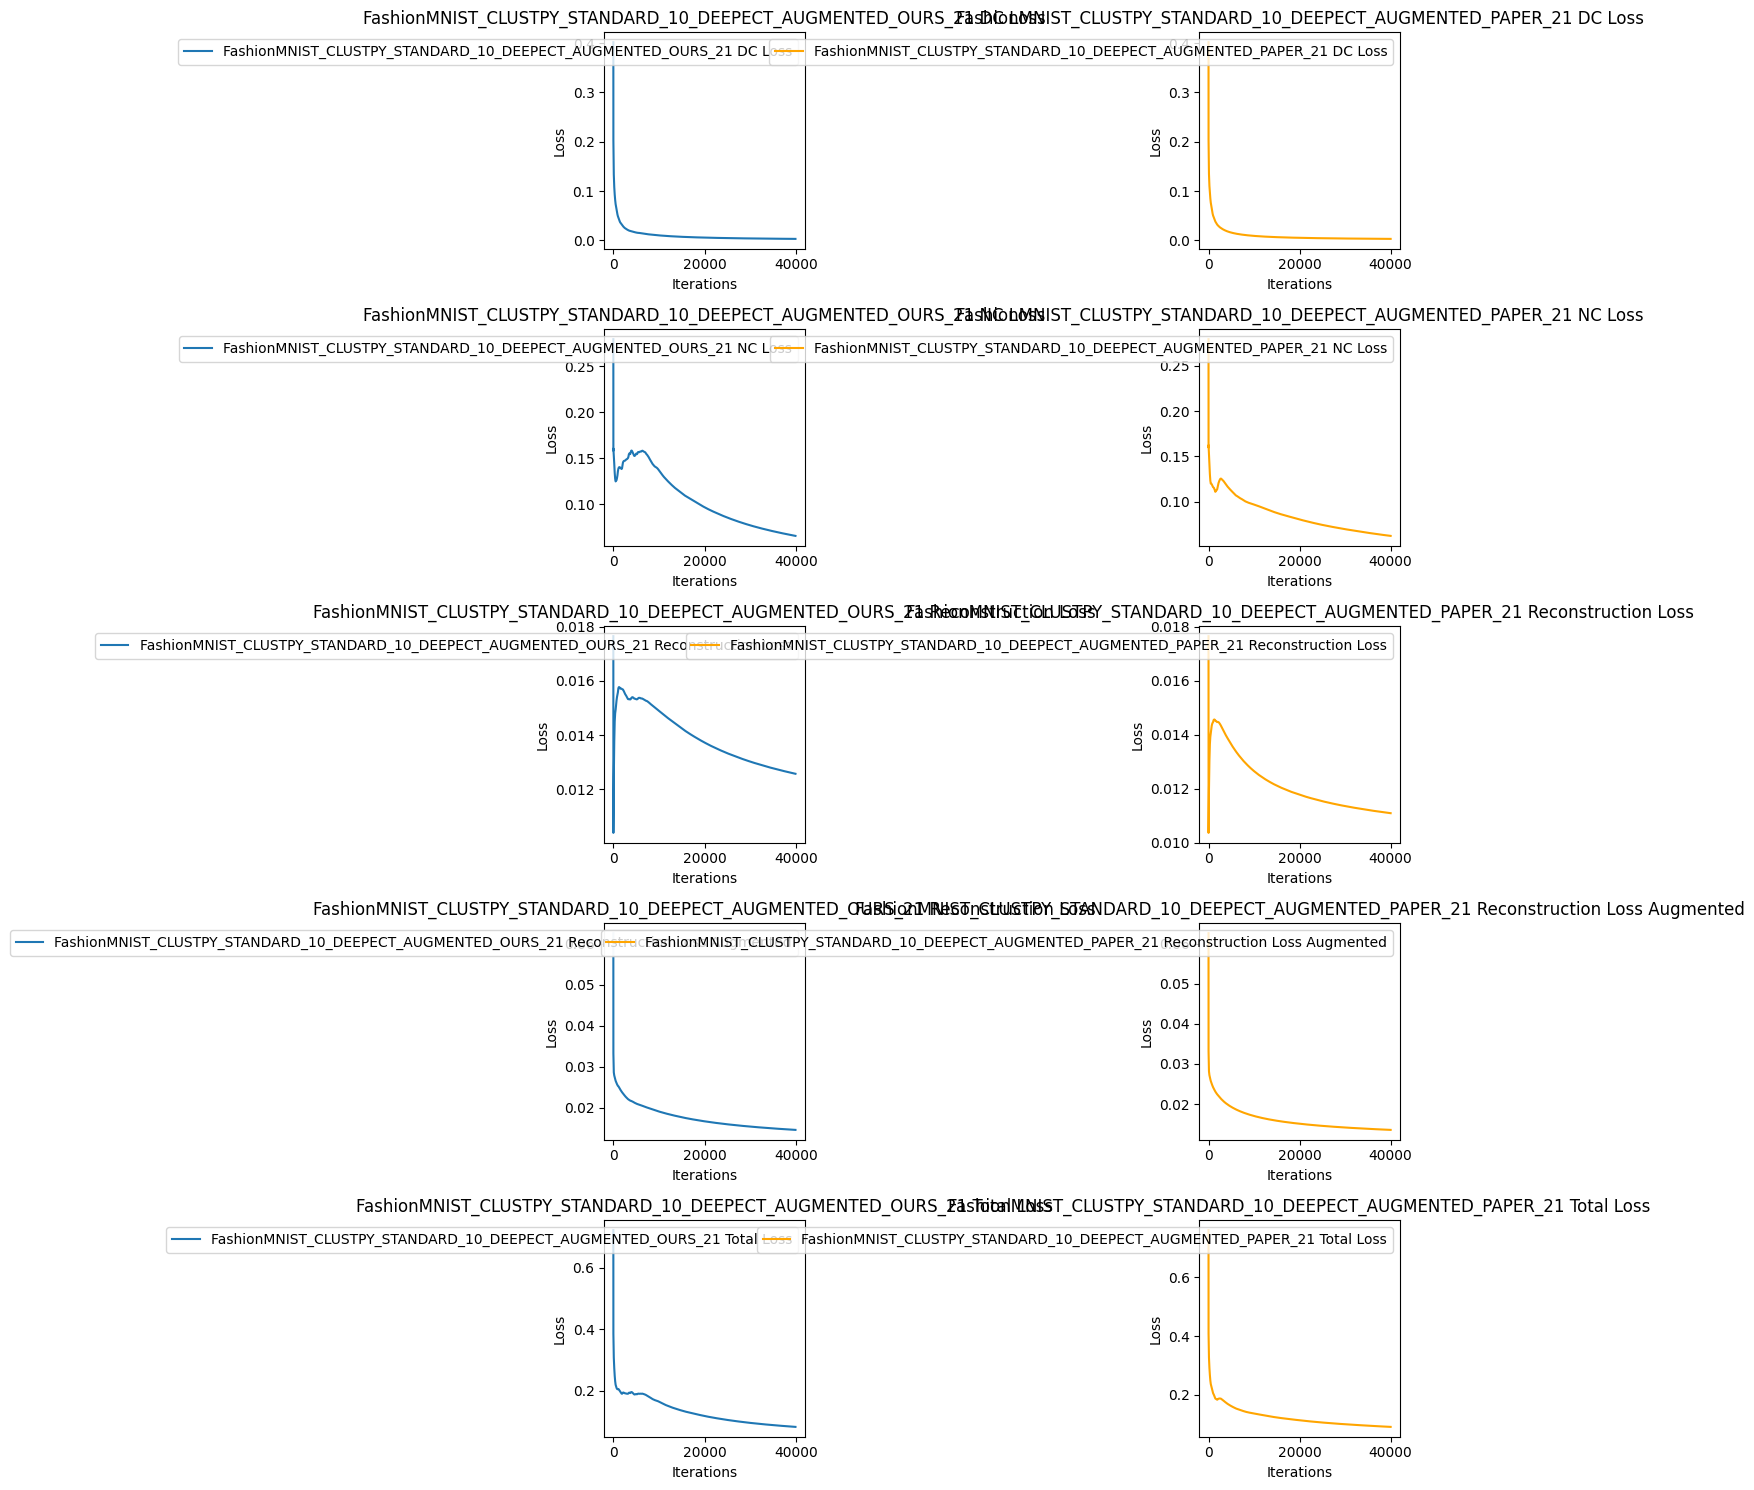

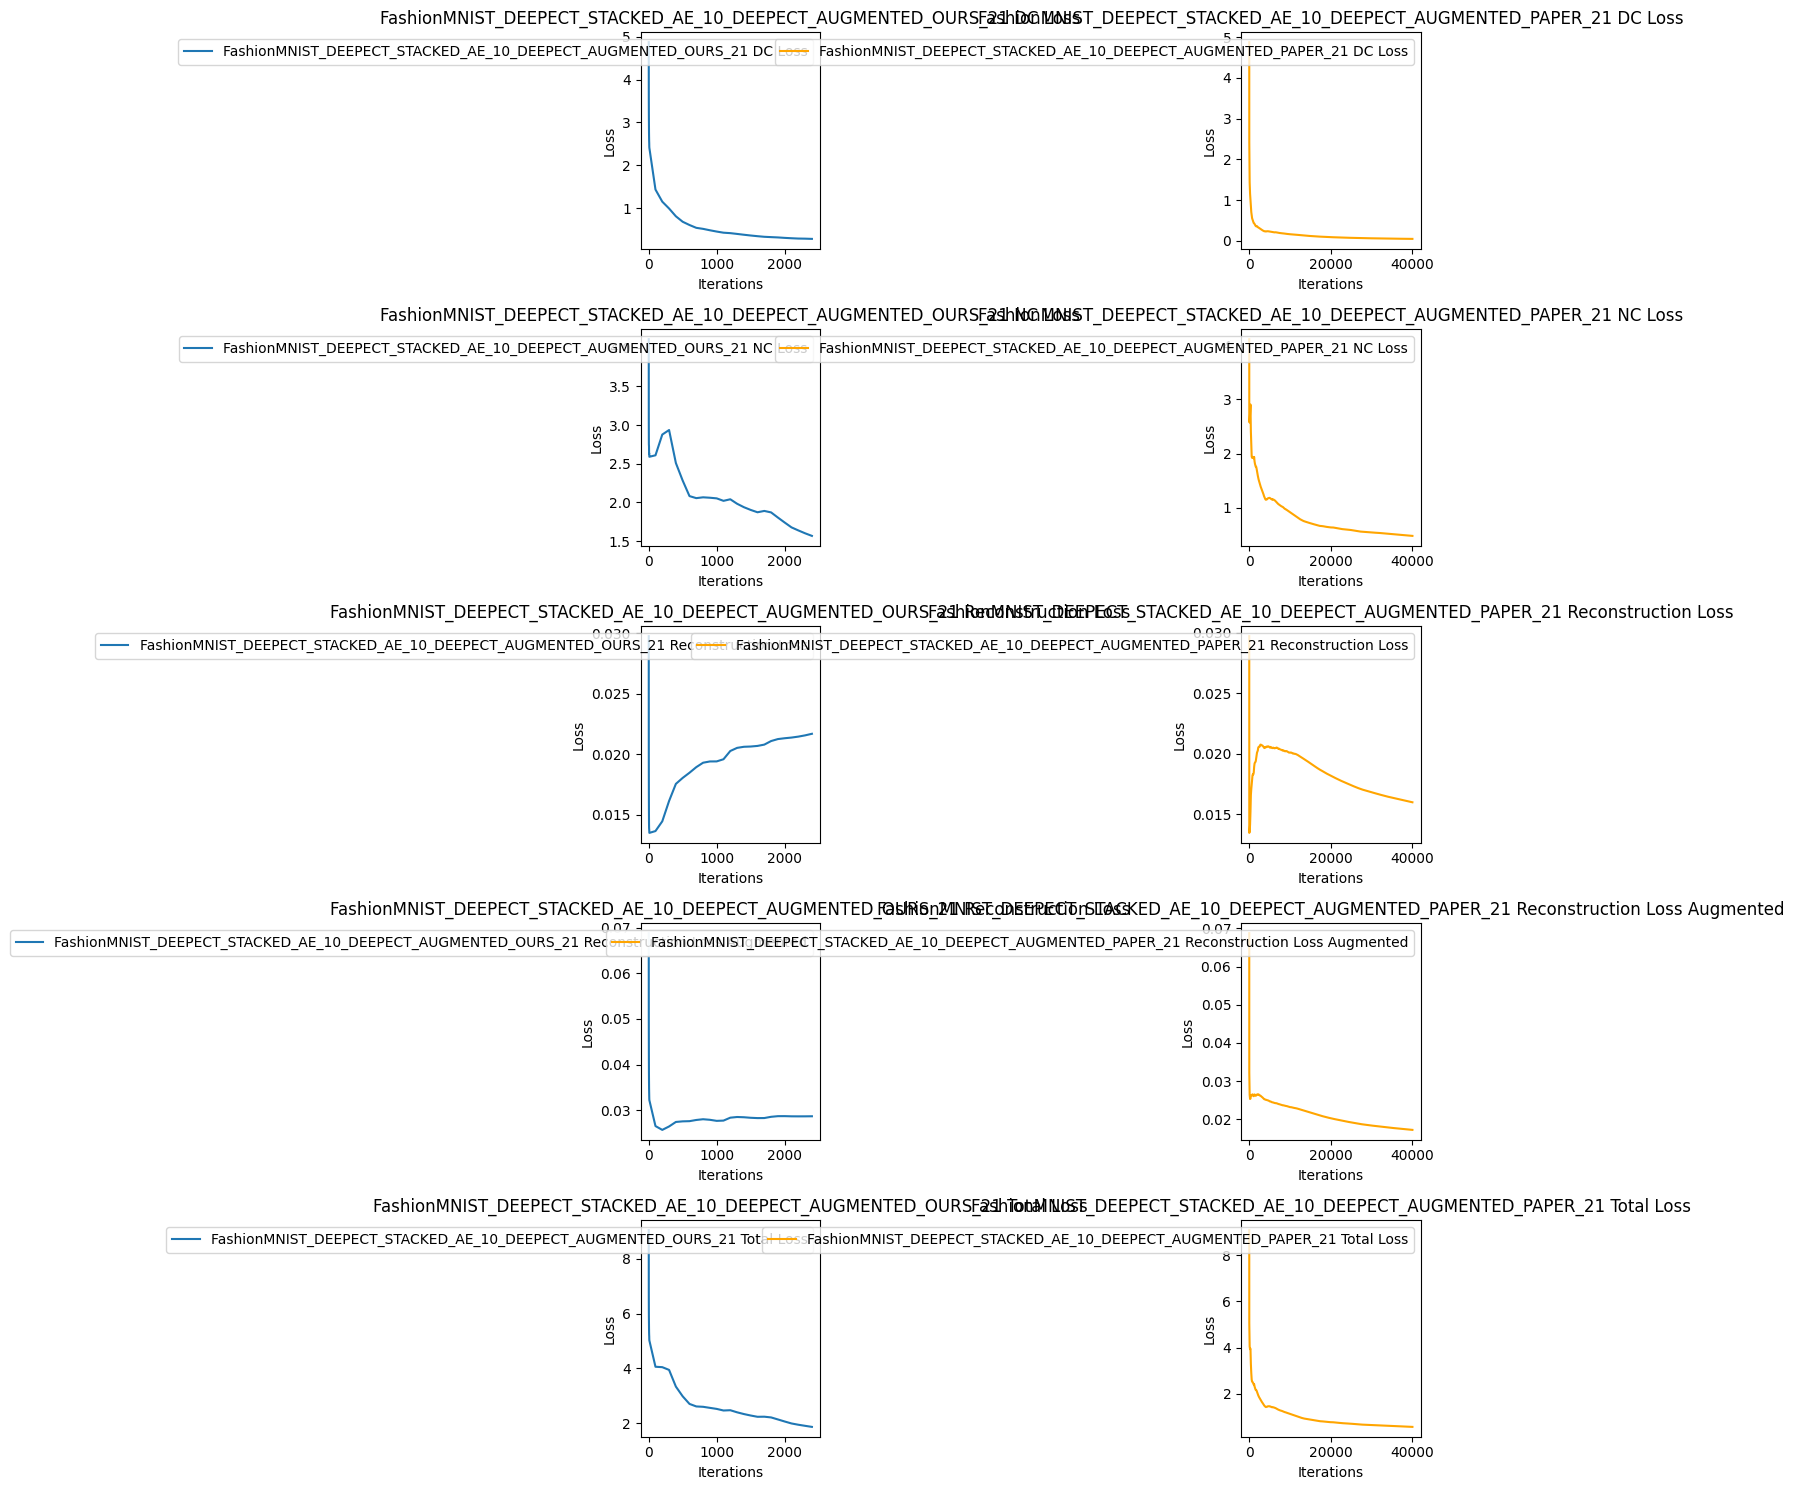

In [147]:
plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.txt'),
plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_PAPER_21.txt')

## USPS


### Standard

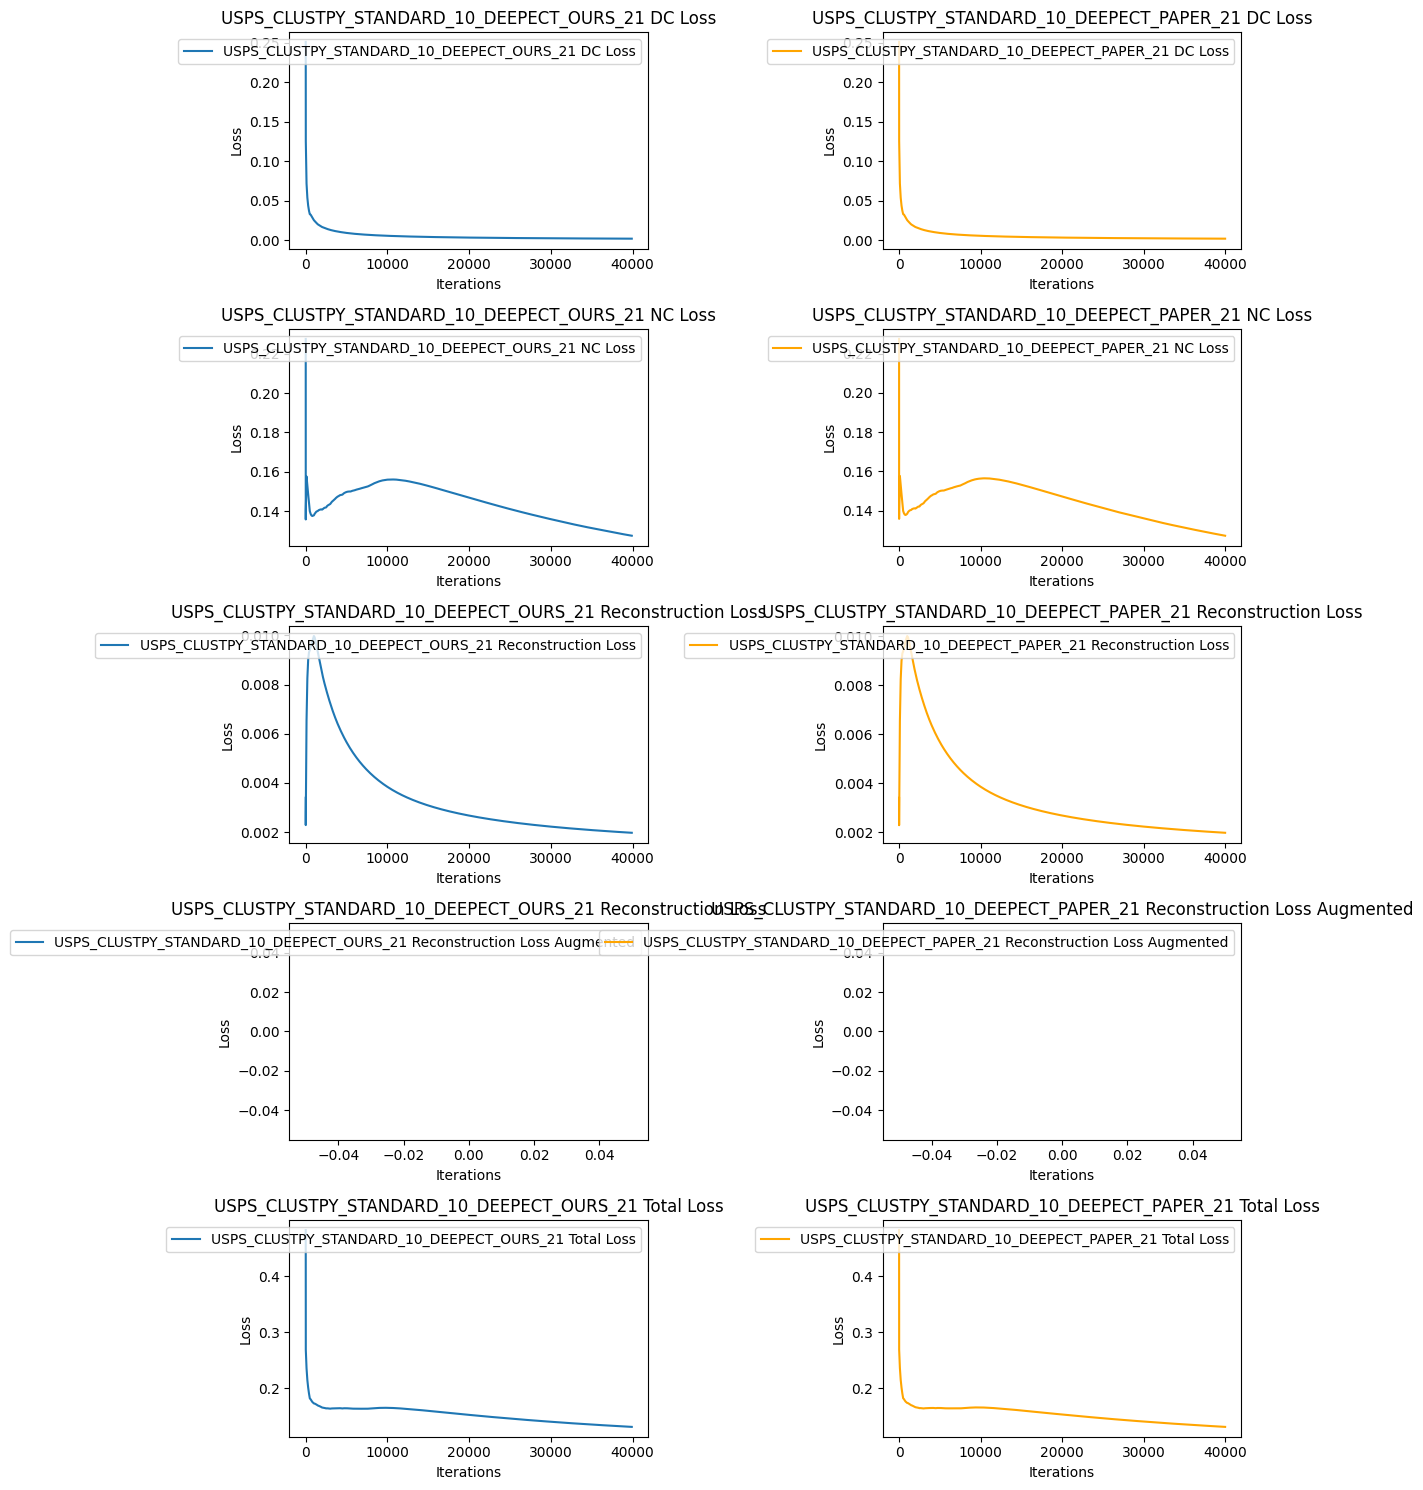

In [148]:
plot_comparison(
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_CLUSTPY_STANDARD_10_DEEPECT_OURS_21.txt",
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.txt",
)

### Stacked

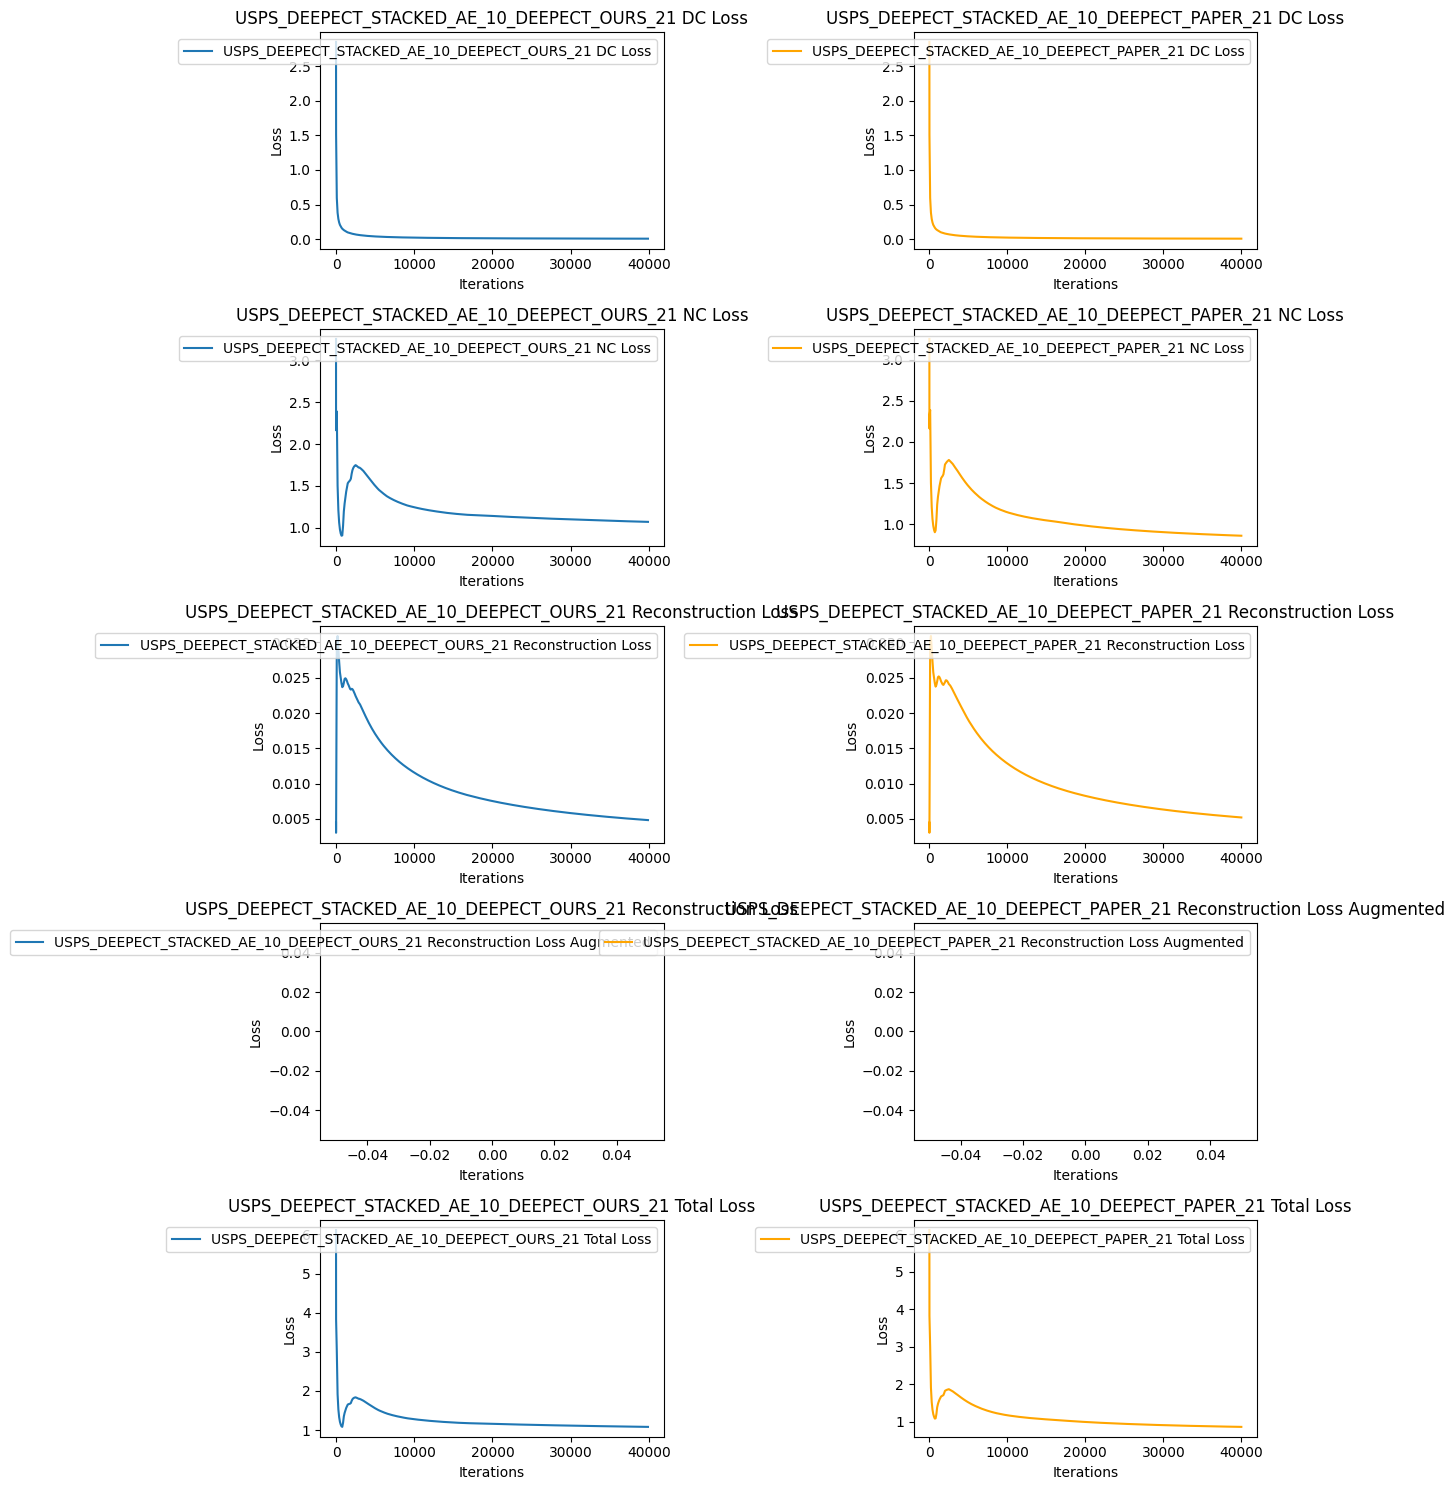

In [159]:
plot_comparison(
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_DEEPECT_STACKED_AE_10_DEEPECT_OURS_21.txt",
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.txt",
)

### Augmented

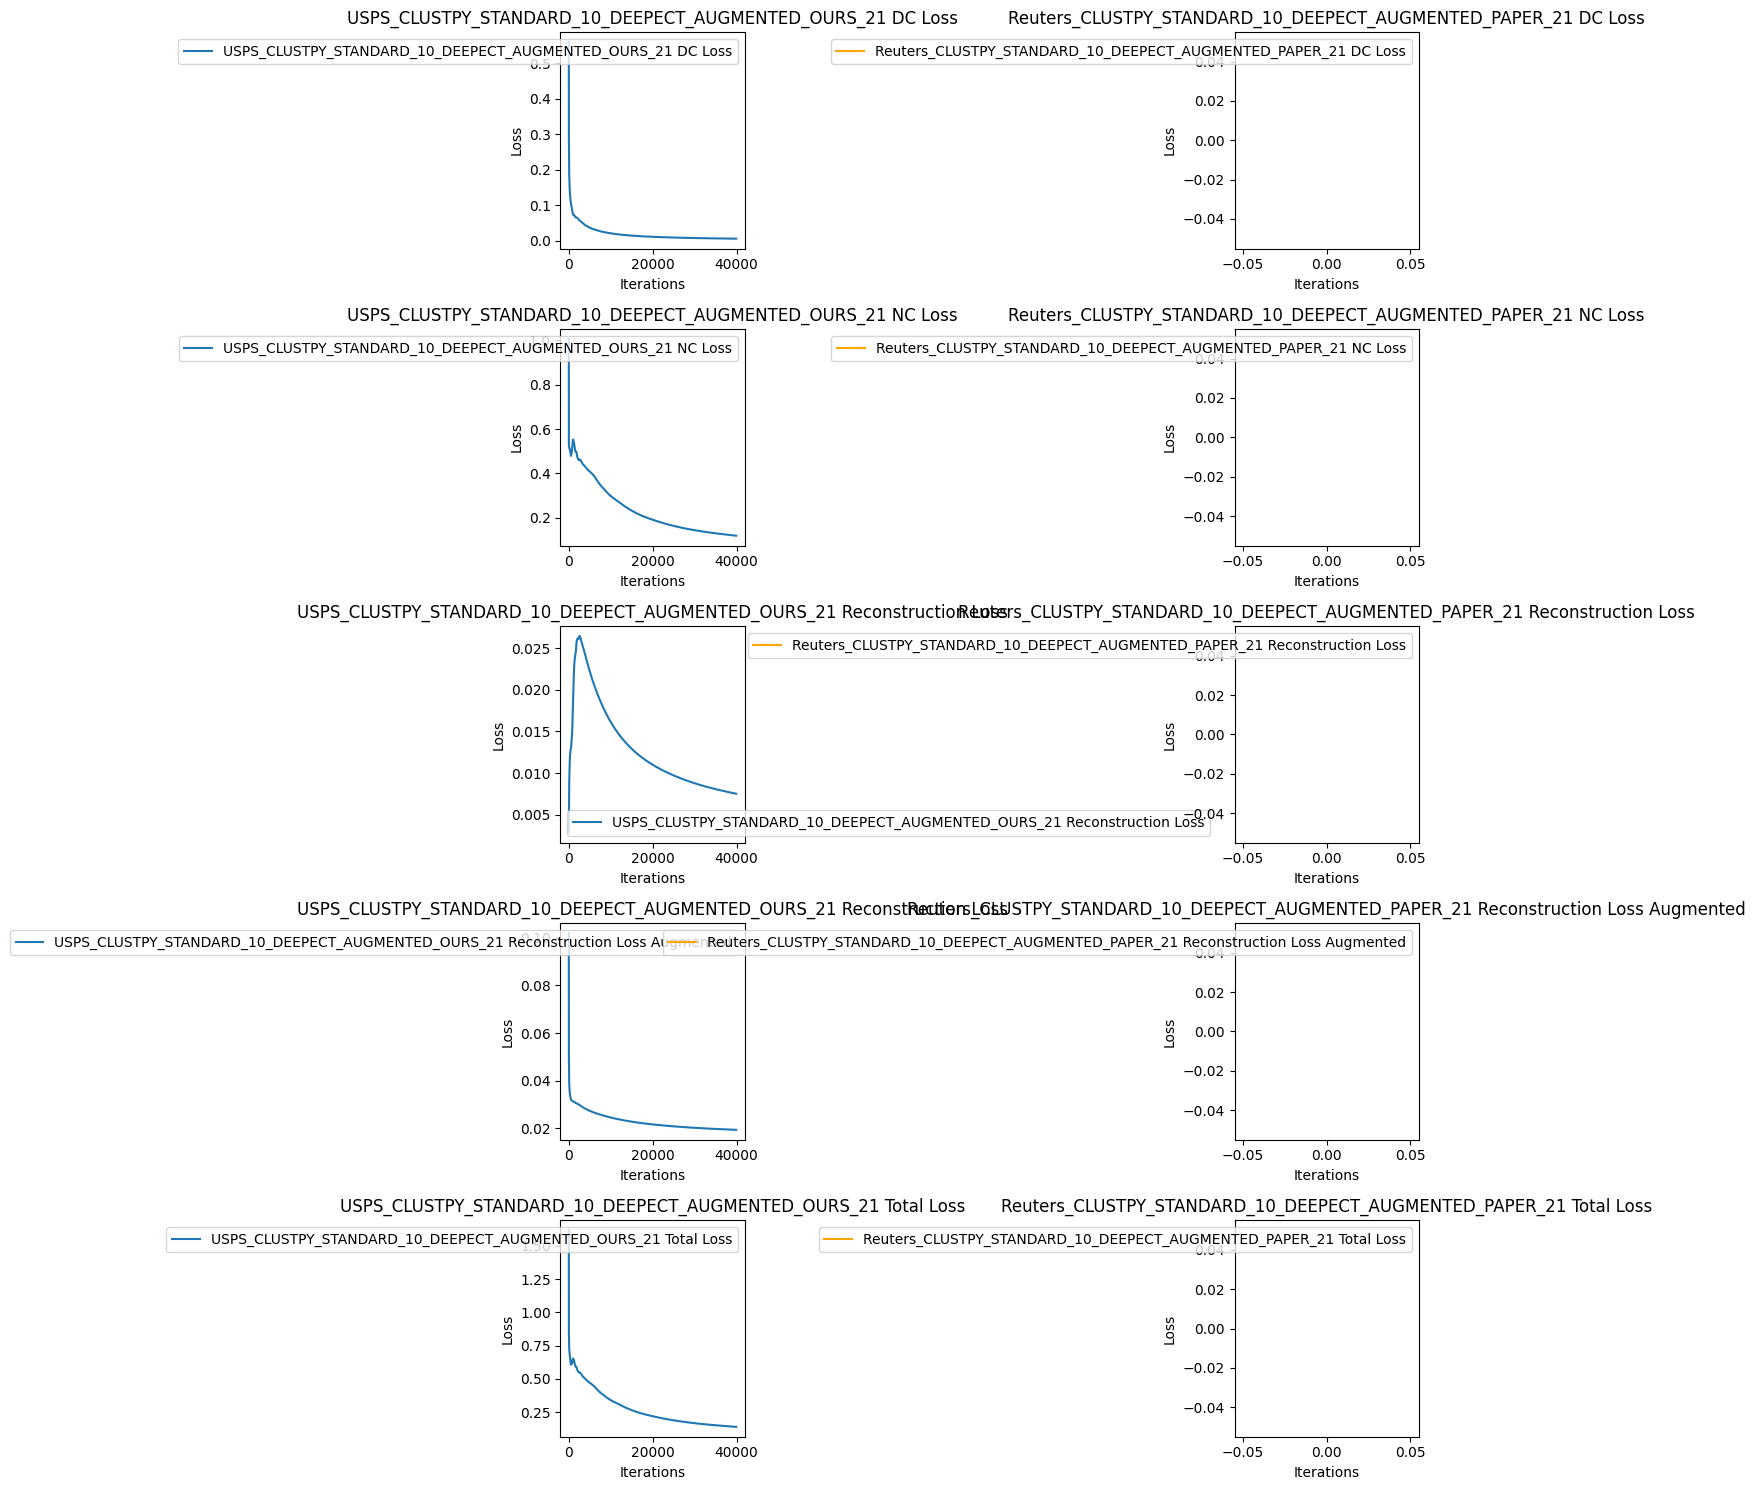

(None,)

In [158]:
plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/Reuters_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.txt'),
# plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/FashionMNIST_DEEPECT_STACKED_AE_10_DEEPECT_AUGMENTED_PAPER_21.txt')

## Reuters

### Standard

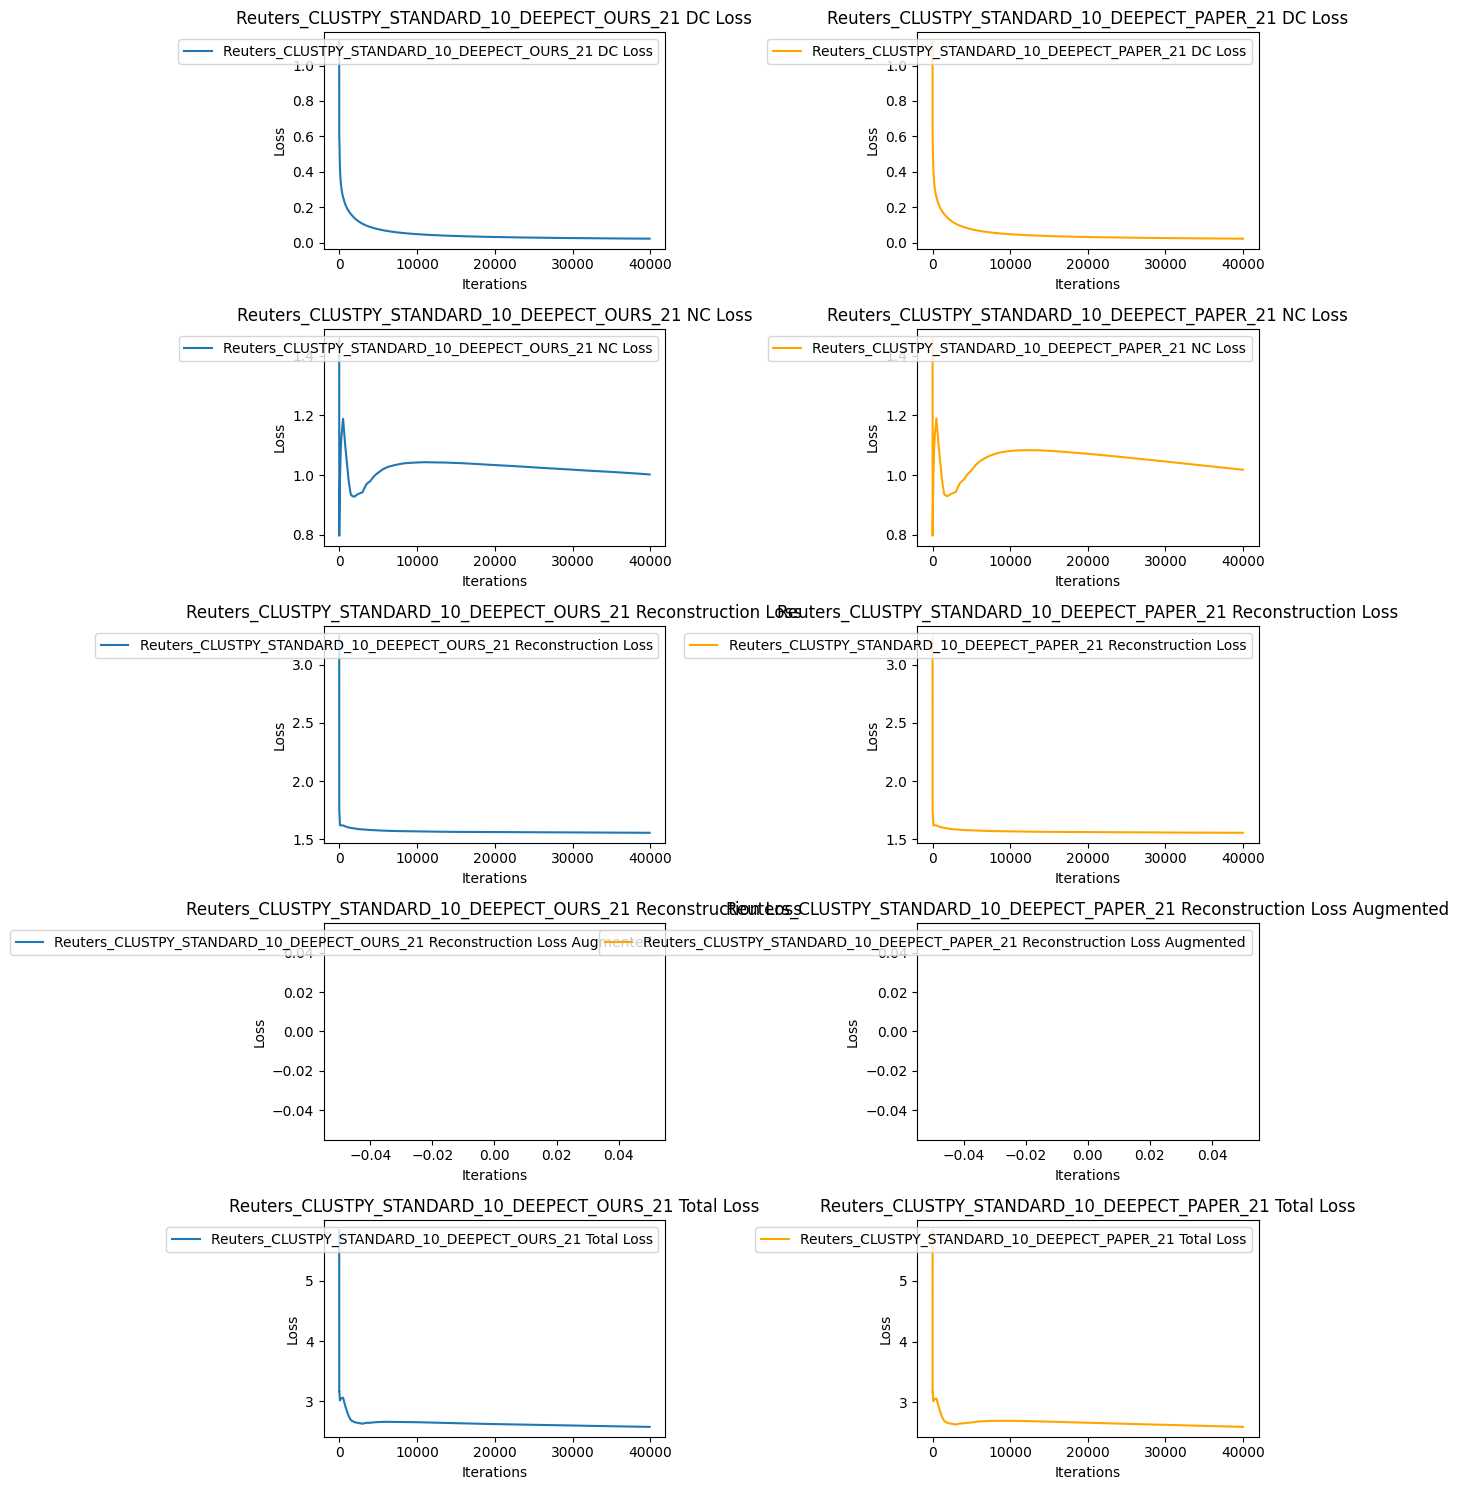

In [157]:
plot_comparison(
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/Reuters_CLUSTPY_STANDARD_10_DEEPECT_OURS_21.txt",
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/Reuters_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.txt",
)

### Stacked

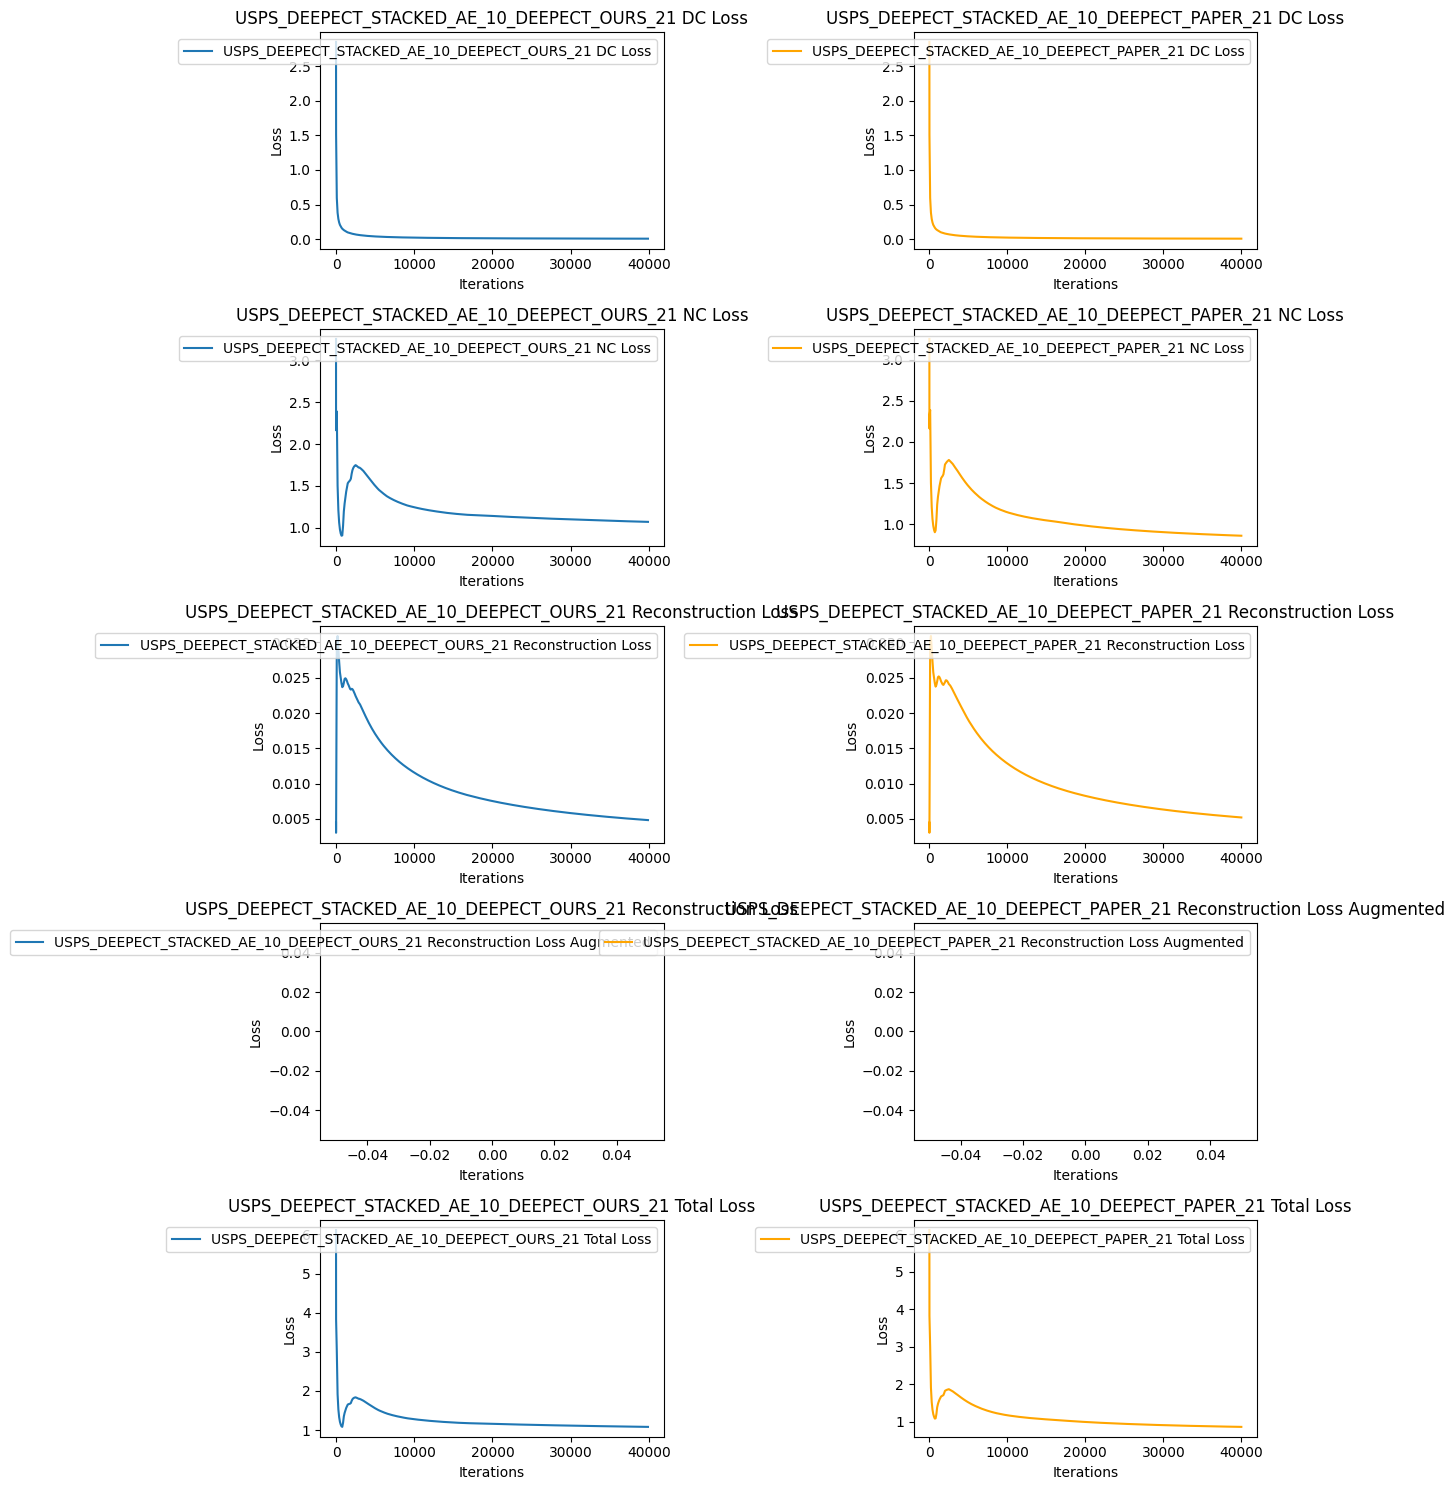

In [160]:
plot_comparison(
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_DEEPECT_STACKED_AE_10_DEEPECT_OURS_21.txt",
    "/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/USPS_DEEPECT_STACKED_AE_10_DEEPECT_PAPER_21.txt",
)

### Augmented

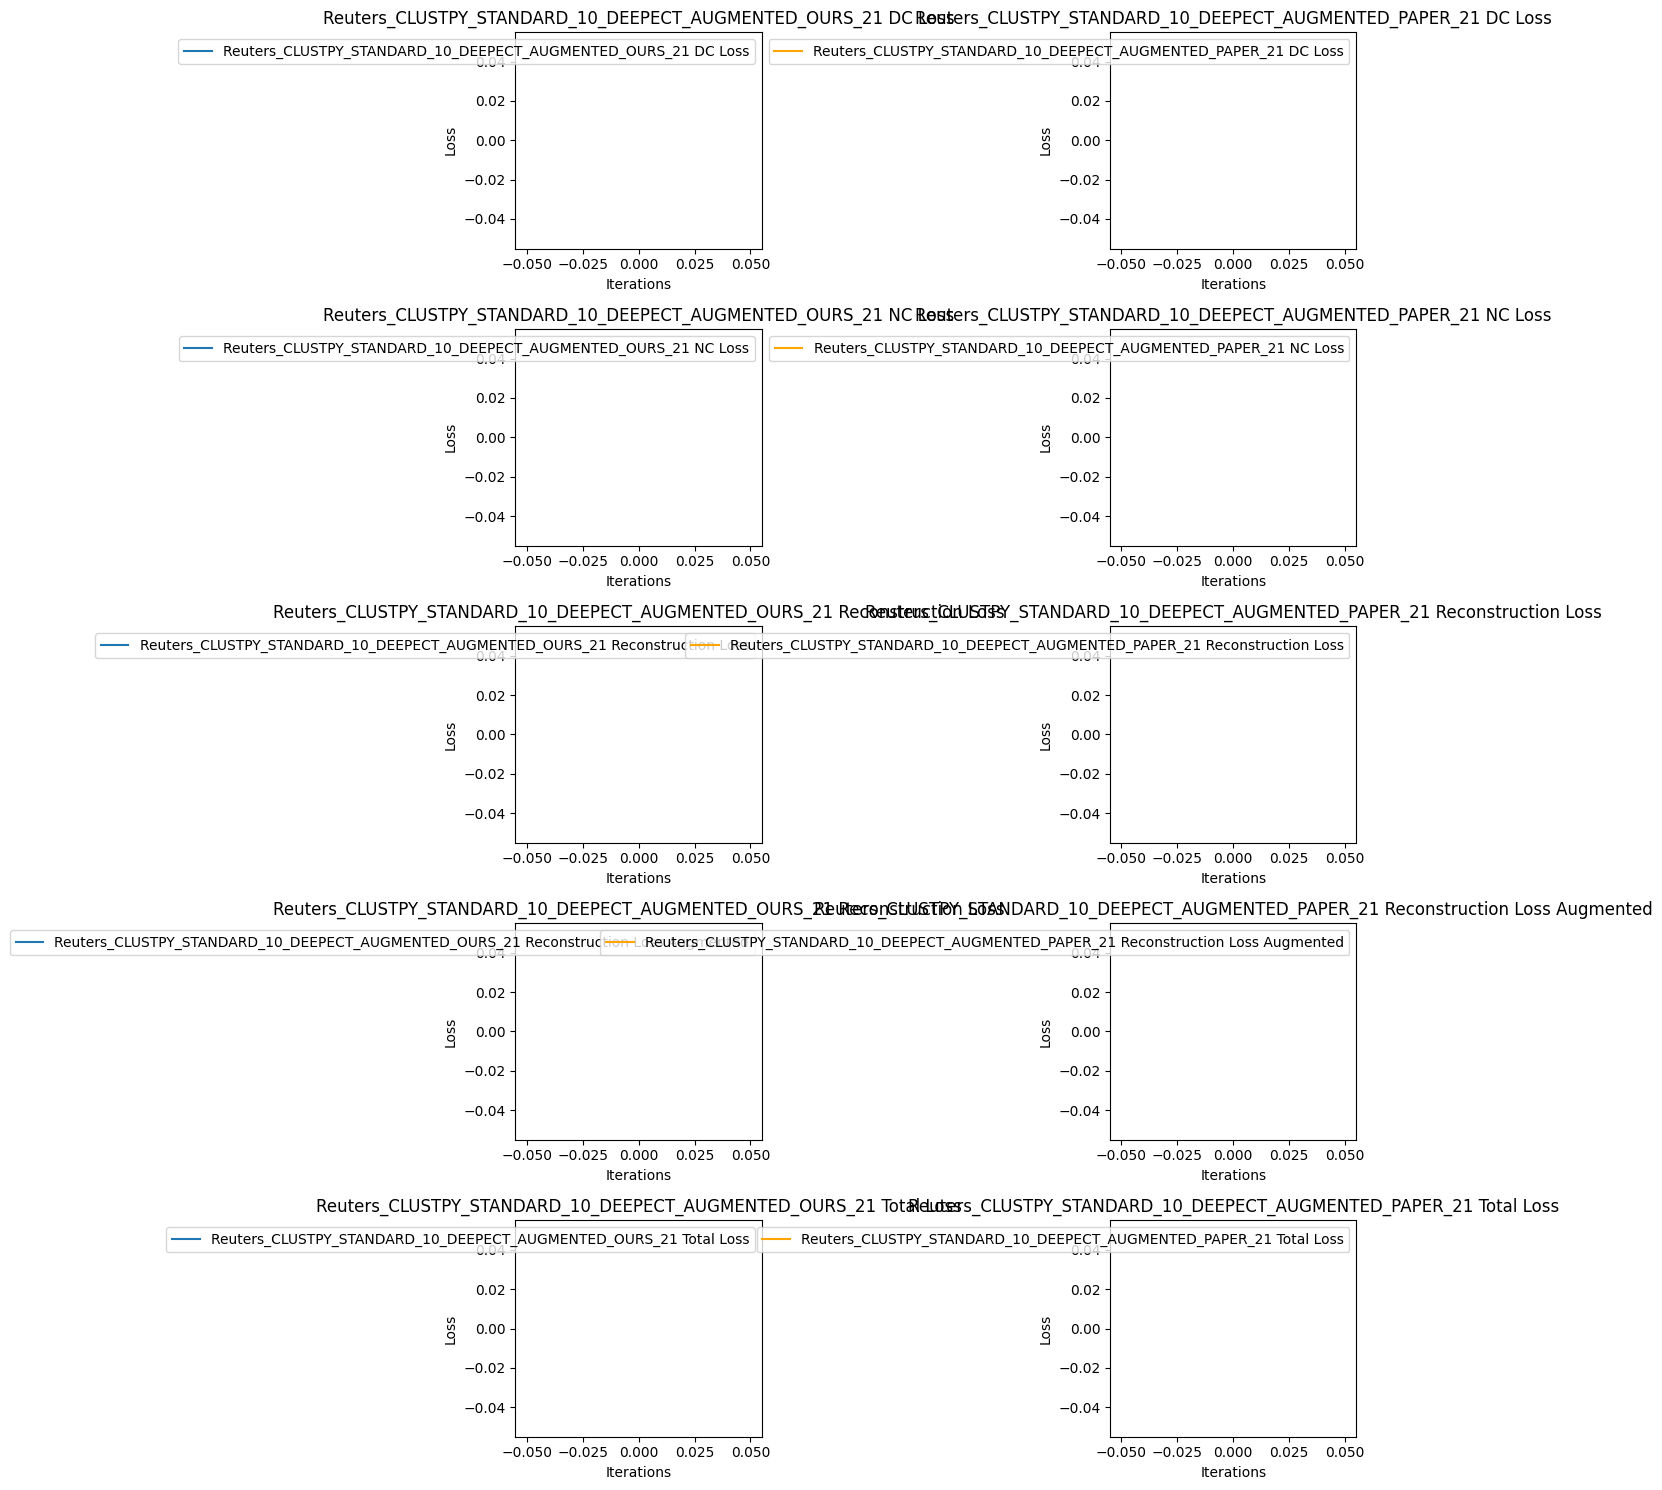

(None,)

In [156]:
plot_comparison('/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/Reuters_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_OURS_21.txt', '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/Reuters_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.txt'),
